In [1]:
#Import useful Python libraries
import pandas as pd #import Pandas
import numpy as np #import Numpy
import datetime as dt #import DateTime library
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import calendar
import folium
import math
from decimal import *
from pywaffle import Waffle

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge


# Capstone Project - For a safer trip - Seatle traffic incidence analysis
### Applied Data Science Capstone by IBM/Coursera


## Table of contents
* [1. Introduction: Business Problem](#introduction) <p hidden>--week 3 requirement--</p>
* [2. Data](#data)
* [3. Methodology](#methodology)
* [4. Analysis](#analysis)
* [5. Results and Discussion](#resultsanddiscussion)
* [6. Conclusion](#conclusion)

# 1. Introduction: Business Problem<a name="introduction"></a>

Seattle, as one of the major cities in North America, has highly developed infrastructures carrying high volumes of road / traffic users all time around.

Some of the "<b>Business Problems</b>" of the metropolitan traffic, may possibly be as follow:
 - What is/are the majority cause of incidence?
 - How severe were the incidents?
 - Where did the incidents happen (mostly)?
 - When did the incidents happen (mostly)?
 - Who were invovled?
 - Are we doing better?

The purpose of this project as described, is targetting to the traffic users and stakeholders of the city to get better insights of the data.

The analysis/discussion/conclusion (based on the dataset we acquired), the above topics are to be covered and, in hope, this project may at least bring some in depth information to the audience about the Seattle traffic.

# 2. Data <a name="data"></a>
#Describe the data (week 2 requirement)

The severity code from the data has been defined as 1 - Property Damange Only Collision and 2 - Injury Collision, whileas other independent features can contribute to the target like "Road condition", "Weather condition", "Type of location" etc. Learning the parttern from these data should bring insights of the traffic data, also understand the trend as time being.

There are 38 columns and 194673 records of incidences in the original dataset. Some of the values are empty or maybe irrelevant to the analysis of this project, and some of the data or its format may not be suitable for analysis.

Data will be loaded, transform and some cleanings are necessary before analysis.

The Data Prepration which takes care of the heavylifting has transform the original data in the following perspectives:
 - Reduced unclear / propriatory / irrelevant / duplicated Data Columns
 - Rename Data Columns to improve understanding
 - Process missing data values (according to their weights):  
   - Dropped minority number of rows with missing important values
   - Filled missing spots with predictable value (i.e. SPEEDING should be either Y or N)
 - Transform Data Columns with "Descritive" status into "Quatifiable" data:
   - Replace Object data type to integer which also representating its quantifiable feature (i.e. Y = 1, N = 0)
   - Create dummy columns for simple binary status which being represented by 1 or 0
   - Date Formatting - Incident Time is a YYYY - MM - DD HH:MM:SS which is important perspective of analysis


### Before Processing
[194673 rows x 38 columns]

In [41]:
#df.drop(['Hours'], axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184167 entries, 0 to 184166
Data columns (total 67 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   X                                     184167 non-null  float64       
 1   Y                                     184167 non-null  float64       
 2   SEVERITY                              184167 non-null  int64         
 3   COLLISION_TYPE                        184146 non-null  object        
 4   PERSON_COUNT                          184167 non-null  int64         
 5   PEDESTRAIN_COUNT                      184167 non-null  int64         
 6   CYCLYST_COUNT                         184167 non-null  int64         
 7   VEHICLE_COUNT                         184167 non-null  int64         
 8   INCIDENT_TIME                         184167 non-null  datetime64[ns]
 9   JUNCTION_TYPE                         184167 non-null  obje

### After Processing
[184167 rows x 71 columns]

In [2]:
#Load the data
path = './Data-Collisions.csv'  #Path is relative.
df_init = pd.read_csv(path)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#Data Preparation
#---Select data for analysis
df = df_init[['X','Y','SEVERITYCODE','COLLISIONTYPE',
                   'PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','INCDTTM','JUNCTIONTYPE',
                   'INATTENTIONIND','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND',
                   'SPEEDING','HITPARKEDCAR']]

#---Rename column to improve understanding
df.rename(columns={"SEVERITYCODE": "SEVERITY","COLLISIONTYPE": "COLLISION_TYPE",
                   "PERSONCOUNT": "PERSON_COUNT","PEDCOUNT": "PEDESTRAIN_COUNT", "PEDCYLCOUNT": "CYCLYST_COUNT",
                   "VEHCOUNT": "VEHICLE_COUNT", "INCDTTM": "INCIDENT_TIME","JUNCTIONTYPE": "JUNCTION_TYPE",
                   "INATTENTIONIND": "INATTENTION","UNDERINFL": "UNDER_INFLUENCE",
                   "ROADCOND": "ROAD_COND","LIGHTCOND": "LIGHT_COND"},inplace = True)
        
#---Drop data with missing value which have lower impact and brings no contribution to analysis
df.dropna(subset=["X","WEATHER","ROAD_COND","LIGHT_COND"], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

#---Filling and unifying some specific values - considering them can only be Y or N
df["SPEEDING"].replace("Y", 1, inplace=True)
df["SPEEDING"].replace(np.nan, 0, inplace=True)
df["INATTENTION"].replace("Y", 1, inplace=True)
df["INATTENTION"].replace(np.nan, 0, inplace=True)
df["UNDER_INFLUENCE"].replace("0", 0, inplace=True)
df["UNDER_INFLUENCE"].replace("N", 0, inplace=True)
df["UNDER_INFLUENCE"].replace("Y", 1, inplace=True)
df["UNDER_INFLUENCE"].replace("1", 1, inplace=True)
df["HITPARKEDCAR"].replace("N", 0, inplace=True)
df["HITPARKEDCAR"].replace("Y", 1, inplace=True)
df["JUNCTION_TYPE"].replace(np.nan, "Unknown", inplace=True)
df.replace("Other", "Unknown", inplace=True)

#---Add necessary parameter for analysis
df['VEHICLEPERSON_COUNT'] = df['PERSON_COUNT'] - df['PEDESTRAIN_COUNT'] - df['CYCLYST_COUNT']

#---Correct the data format
df[['INCIDENT_TIME']] = pd.to_datetime(df['INCIDENT_TIME'])

#---Transform Columns into quatifiable values
#"WEATHER"
df_dump = pd.get_dummies(df['WEATHER'])
df = pd.concat([df, df_dump], axis=1)
df.rename(columns={"Blowing Sand/Dirt": "WT_BlowingSandDirt","Clear": "WT_Clear","Fog/Smog/Smoke":"WT_FogSmogSmoke",
                   "Overcast":"WT_Overcast","Partly Cloudy":"WT_PartlyCloudy","Raining":"WT_Raining",
                   "Severe Crosswind":"WT_SevereCrosswind","Sleet/Hail/Freezing Rain":"WT_SleetHailFreezingrain",
                   "Snowing":"WT_Snowing","Unknown":"WT_Unknown"
                  }, inplace = True)
#df.drop(["WEATHER"], axis=1, inplace=True)

#"COLLISION_TYPE"
df_dump = pd.get_dummies(df['COLLISION_TYPE'])
df = pd.concat([df, df_dump], axis=1)
df.rename(columns={"Angles": "ClTp_Angles","Cycles": "ClTp_Cycles","Head On":"ClTp_HeadOn",
                   "Left Turn":"ClTp_LeftTurn","Parked Car":"ClTp_ParkedCar","Pedestrian":"ClTp_Pedestrian",
                   "Rear Ended":"ClTp_RearEnded","Right Turn":"ClTp_RightTurn","Sideswipe":"ClTp_Sideswipe",
                   "Unknown":"ClTp_Unknown"
                  }, inplace = True)
#df.drop(["COLLISION_TYPE"], axis=1, inplace=True)

#"ROAD_COND"
df_dump = pd.get_dummies(df['ROAD_COND'])
df = pd.concat([df, df_dump], axis=1)
df.rename(columns={"Dry": "RoadCond_Dry",
                   "Wet": "RoadCond_Wet",
                   "Ice": "RoadCond_Ice",
                   "Oil": "RoadCond_Oil",
                   "Sand/Mud/Dirt": "RoadCond_SandMudDirt",
                   "Snow/Slush":"RoadCond_SnowSlush",
                   "Standing Water":"RoadCond_StandingWater",
                   "Unknown":"RoadCond_Unknown"
                  }, inplace = True)
#df.drop(["ROAD_COND"], axis=1, inplace=True)

#"LIGHT_COND"
df_dump = pd.get_dummies(df['LIGHT_COND'])
df = pd.concat([df, df_dump], axis=1)
df.rename(columns={"Dark - No Street Lights": "LtCond_DarkNoStLgt",
                   "Dark - Street Lights Off": "LtCond_DarkStLgtOff",
                   "Dark - Street Lights On":"LtCond_DarkStLgtOn",
                   "Dark - Unknown Lighting":"LtCond_DarkUnknownLgt",
                   "Dawn":"LtCond_Dawn","Daylight":"LtCond_Daylight",
                   "Dusk":"LtCond_Dusk","Unknown":"LtCond_Unknown"
                  }, inplace = True)
#df.drop(["LIGHT_COND"], axis=1, inplace=True)

#"JUNCTION_TYPE"
df_dump = pd.get_dummies(df['JUNCTION_TYPE'])
df = pd.concat([df, df_dump], axis=1)
df.rename(columns={"At Intersection (but not related to intersection)": "JcTp_IntersectionNotRelated",
                   "At Intersection (intersection related)": "JcTp_IntersectionRelated",
                   "Driveway Junction":"JcTp_DrivewayJunction",
                   "Mid-Block (but intersection related)":"JcTp_MidBlock_IntersectionRelated",
                   "Mid-Block (not related to intersection)":"JcTp_MidBlock_IntersectionNotRelated",
                   "Ramp Junction":"JcTp_RampJunction","Unknown":"JcTp_Unknown"
                  }, inplace = True)
#df.drop(["JUNCTION_TYPE"], axis=1, inplace=True)

#"SEVERITY" -- *This should go at the last
df_dump = pd.get_dummies(df['SEVERITY'])
df = pd.concat([df, df_dump], axis=1)
df.rename(columns={1: "Severity_1", 2: "Severity_2"}, inplace = True)
#df.drop(["SEVERITY"], axis=1, inplace=True)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-3-e73ff7b0e1ec>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["X","WEATHER","ROAD_COND","LIGHT_COND"], axis=0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

# 3. Methodology <a name="methodology"></a>
#Describe the Methodology (week 2 requirement)

In this project, we will direct our efforts on identifying the most possibly contributive factors to major incidents with higher severity (Severity 2 - Injury & Damange).

Meanwhile, we shall also look at some other factors by exploring throught the data to identify some characteristics of Seattle's traffic along 15 years of time (2004 ~ 2019... while 2020 is unfortunately with unpresidented situation)

#### [Exploratory Analysis](#Ex-analysis)

As we will navigate through the data in the time, space and some other perspetives as the environment or the driver's status while the incident occurred.

From the exploratory analysis we may also draw some conclusion to narrow down the scope for further analysis, by identifying the noticeable contributive factors to higher severity incident, and also the "right way" to look for it (i.e. dimension of time:  Same hours through all time?  Same months?  or spae like Junction type)

#### [Modeling and Evaluation](#Model-Eva)

After the exploratory analysis and initial scoping down to the contributive factors, we are going to build same data analytic models using some machine learning libraries.  Then, identify the most usable model by evaluating them.

From this session, we may make some prediction using the selected model and try to picture one or a few possible future of what traffic may look like in Seattle (by the meaning of Incident counts)

#### *Note:
Given indefinite resources (time especially), there are corresponding amount probabilities of discovering newer dimensions / perspectives and many possible discussion or conclusions using the same set of data.  As well, the author's limitation of capability has set the cap of this analysis based on selected methodologies, dataset and scenarios be used in this project.  The door of Further discussion is ALWAYS OPENED.


## 4. Analysis <a name="analysis"></a>

(Yours here)

<b>(Example)</b><br><p>
Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the **number of restaurants in every area candidate**:
</p><br><b>(/Example)</b>

In [5]:
#---Data preparation for exploratory analysis
df_time = df
df_time['Year'] = df_time.INCIDENT_TIME.dt.year
df_time['Month'] = df_time.INCIDENT_TIME.dt.month
df_time['Day'] = df_time.INCIDENT_TIME.dt.day
df_time['Hour'] = df_time.INCIDENT_TIME.dt.hour

df_Env = df

def ExpDataSelect(Input, Period):

    if Input == 'Weather':
        Output = df_time[[Period,'WT_BlowingSandDirt','WT_Clear','WT_FogSmogSmoke','WT_Overcast',
                    'WT_PartlyCloudy','WT_Raining','WT_SevereCrosswind','WT_SleetHailFreezingrain',
                    'WT_Snowing','WT_Unknown']].groupby([Period], as_index = True).sum()
    elif Input == 'Road Condition':
        Output = df_time[[Period,'RoadCond_Dry','RoadCond_Wet','RoadCond_Ice','RoadCond_Oil',
                    'RoadCond_SandMudDirt','RoadCond_SnowSlush','RoadCond_StandingWater','RoadCond_Unknown']].groupby([Period], as_index = True).sum()
    elif Input == 'Light Condition':
        Output = df_time[[Period,'LtCond_DarkNoStLgt','LtCond_DarkStLgtOff','LtCond_DarkStLgtOn','LtCond_DarkUnknownLgt',
                    'LtCond_Dawn','LtCond_Dusk','LtCond_Daylight','LtCond_Unknown']].groupby([Period], as_index = True).sum()
    elif Input == 'Incident Features':
        Output = df_time[[Period,'SPEEDING','UNDER_INFLUENCE','INATTENTION']].groupby([Period], as_index = True).sum()
    elif Features == 'Junction Type':
        Output = df_time[[Period,'JcTp_IntersectionNotRelated','JcTp_IntersectionRelated','JcTp_DrivewayJunction',
                    'JcTp_MidBlock_IntersectionRelated','JcTp_MidBlock_IntersectionNotRelated',
                    'JcTp_RampJunction','JcTp_Unknown']].groupby([Period], as_index = True).sum()
    elif Input == 'Collision Type':
        Output = df_time[[Period,'ClTp_Angles','ClTp_Cycles','ClTp_HeadOn','ClTp_LeftTurn','ClTp_ParkedCar',
                    'ClTp_Pedestrian','ClTp_RearEnded','ClTp_RightTurn','ClTp_Sideswipe','ClTp_Unknown']].groupby([Period], as_index = True).sum()
    elif Input == 'Casualties':
        Output = df_time[[Period,'VEHICLEPERSON_COUNT','PEDESTRAIN_COUNT','CYCLYST_COUNT','VEHICLE_COUNT']].groupby([Period], as_index = True).sum()
    elif Input == 'Severities':
        Output = df_time[[Period,'Severity_1','Severity_2']].groupby([Period], as_index = True).sum()
    else:
        print("Features available are: Weather / Road Conditions / Light Contidtions / Incident Features / Junction Type / Collision Type / Severities")
        return None

    return Output
        
def LinePlot(DataSet, Period, Title):
    x = list(DataSet.columns.values)
    y = list(DataSet.index.values)
    
    #line plot
    DataSet.plot(kind='line',
                 figsize = (20, 8)
                )
    plt.title(Title, size = 16)
    #plt.xlabel("Month", size = 14)
    plt.ylabel("# of Incidences", size = 14)
    if Period == 'Month':
        plt.xticks(np.arange(df_temp.index.values.size), calendar.month_abbr[1:13], rotation=60)
    else:
        plt.xticks(DataSet.index, DataSet.index.values, rotation=0)
    plt.legend(prop={"size":14})
    plt.show()
    
    #Heatmap
    plt.pcolor(DataSet, cmap = 'RdBu')
    plt.ylabel(Period, size = 14)
    if Period == 'Month':
        plt.xticks(np.arange(DataSet.columns.values.size), x, rotation=65)
        plt.yticks(np.arange(df_temp.index.values.size), calendar.month_abbr[1:13], rotation=0)

    else:
        plt.xticks(np.arange(DataSet.columns.values.size), x, rotation=65)
        plt.yticks(np.arange(DataSet.index.values.size), y, rotation=0)
    plt.colorbar()
    plt.show()
    DataSet
    
def BarPlot_Severity(Feature, Title): #Feature as the data set

    if Feature == 'Incident Feature':
        df_temp = df_Env[['SPEEDING','INATTENTION','UNDER_INFLUENCE','Severity_1','Severity_2']]
        df_temp = df_temp.groupby(['SPEEDING','INATTENTION','UNDER_INFLUENCE'], as_index = True).sum()
        df_temp['INCIDENT_FEAT'] = ['Unknown - Not Under Influence, Inattention Or Speeding','Under Influence',
                                    'Inattention','Under Influence & Inattention','Speeding',
                                    'Under Influence & Speeding','Inattention & Speeding',
                                    'Under Influence, Inattention & Speeding']
        df_temp.set_index('INCIDENT_FEAT',inplace = True)
    else:
        df_temp = df_Env[[Feature,'Severity_1','Severity_2']]
        df_temp = df_temp.groupby([Feature], as_index = True).sum()
    
    x = list(df_temp.columns.values)
    y = list(df_temp.index.values)

    df_temp.plot(kind = 'barh',
           figsize = (20, 8),
           width = 0.9,
           #color = ['#d9534f','#5bc0de']
           )
    plt.title(Title, size = 16)
    plt.ylabel(Feature, size = 14)
    plt.xlabel("# of Incidents", size = 14)
    #plt.gca().invert_yaxis()
    #plt.xticks(rotation=60)
    plt.yticks(np.arange(df_temp.index.values.size), y, rotation=0)
    plt.legend(df_temp.columns.values)

    for i in range(len(df_temp.index)):
        for index, value in enumerate(df_temp.values[i]):
            plt.text(value, i-0.2+index/3.5, str(value))
 
    plt.show()

## 4.1 Epxploratory Analysis <a name="Ex-analysis"></a>


### 4.1.1 [Overall thrend of incident through the period](#Ex-analysis411)
The <b>[Incident Trend](#figure411-1)</b> is trending downwards while the <b>[Casualty Trend](#figure411-2)</b> has the similar trend.  Apparently the pandemic has caused signicant drop of records in 2020 which we may ignore in any case coming across the same year.

From the perspectives of <b>[incident features](#figure411-3)</b> (i.e. Speeding, Inattention, Under Influence), and the <b>[type of collision](#figure411-4)</b>, the overall trends appear to be similar to what we found as the incident trend.  HOWEVER, there are some exceptions:
 * There was a surge of <b>Inattention</b> incidents from 2014.  Even the trend started to calm down but still act as a significant majorirty of incident type.
 * There maybe lack of information before 2014, of incidents which involved a parked car.  The record shows it begins from 2014 then walk a similar trend with its peers.
 * Interesting finding that the "hit a parked car" record is inconsistent in the collision type against the incident feature records.
 
With no much surprise when we look into the location where the incidents happened (by <b>[Junction Type](#figure411-5)</b> which appears to be very similar trend as the total incidents through the whole period.


### 4.1.2 [Time sensitive features (Weather, Road condition & Light Condition)](#Ex-analysis412)
We might found very similar situation while extending our scout into the environmental factors (Weather, Road Condition, Light Conditions).  But that is not enough

As <b>[Weather](#figure412-9)</b> goes with seasonal pattern in particular climate (i.e. Seattle), the period set to be month may explain more about how weather affects incident rate. Despite exceptional weather conditions, the overall <b>[Pattern of Incident Trend per Weather condition of the same month of all the yeras](#figure412-9a)</b> when incidents happened match.

<b>[Road condition](#figure412-10)</b> is mostly depending on the weather.  Applying the same analysis criteria produce consistent result just like Weather.  Seattle weather is almost visible from the incident line graph either from Weather or Road Condition through months of the year.

##### *Light Condition
<b>[Light condition](#figure412-11)</b> is a little bit complex.  It can be affected by the climate. Given the climate in Seattle, which usually having a greyish or even darker greyish sky during winter time, and the latitude of N47ish will have longer dark hours in winter and longer daylights during summer.  

In this case we found the parttern by looking at the trend by Hours and further to segregate by each month.  the <b>[Trend of Incidents by Lighting Conditions](#figure412-12a)</b> appear to be running the same pattern round the hours and season changes have surprisingloy, not contributed too much to this pattern.

There is one odd point of data, that daylight cases should NOT happend @ 00:00 of the day.  There maybe incorrect record in tiem format (12am / 12pm have all been convered to 0 o'clock), or it was seeded from the origin.


### 4.1.3 [Incident Catagorization & Distribution](#Ex-analysis413)
Let's look at the incident data from its catagorization and compare them across the features.  With comparison, the initial impression of "What is/are the majority cause of incidence" may preveal.   Otherwise, we may conclude what are the top contribution factors by learning the history.

How is <b>[Weather contributing to incidents](#figure413-2)</b> ?  Per observation of the plot, we may find that:
- Clear days have obviously the most incidents, Severity 1 or 2.
- If clear days has the most is surprising, the “rainy days” has the 2nd most incident sounds more intuitive.
- the 3rd place is “Overcast / Cloudy” weather which have both slightly less incident counts then in the rainy days.

There is a type of weather called “Unknown” which indicates it’s neither being recorded or indescribable.  We maybe able to trace back to the date and lookup the weather in other data source.  Here it reads the 4th place contributing to incident.

Snowing is 5th place and much less than rainy days.  It is understandable that Seattle as the southern neighbour of its sister city Vancouver which has already has much less snows, should count rainy days instead of white out roads.

Fog/Smog/Smoke and those minorities of weather conditions contribute very minimum which we may take a note on.


<b>[Road Conditions](#figure413-3)</b> has super close relationship to Weather, which may not be a surprise.  Dry roads (the weather may be clear as well) has the most incidents number and took up nearly 50%+ of the overall incidents count.  Wet counts next to Dry and then apparently the “Unknown” kicks in.

<b>[Light Conditions](#figure413-4)</b> has a different affect to incident but still more than half of the cases happened during broad daylight.  As well, the 2nd runner up is during the dark, HOWEVER with street lights on.

Dimmer environments like No street light/light off contributed to the count.  And of which worth being noticed that <b>Dusk and Dawn have more cases</b>.  Consideration could be due to busier traffics (Transit rushes)

Continue looking for the Collision Type of Incidences (413-4), hitting parked car took the lead in Severity 2 cases while Rear Ended tops the Severity 1 incident, with Angles collision running super closed behind.

Severity 2 cases overwhelmed (nearly 10x) Severity 1 cases in collision that involves Pedestrian and Cyclist. 

<b>Left turn</b> caused incident is worth noticing.  As in North America, left turn is being considered to be more complicated and higher risk manoeuvre on the road.

<b>[Junction Types](#figure413-5)</b> of where incidents happened indicates most cases happened in the middle of the city road (Mid-block no interception).  HOWEVER, most Severity 2 cases happened in the interception (and also related to the very interception).  This is becoming quite obvious and the most complicated place where traffics from all directions meet.

Last but not least, the <b>[Incidence Features](#figure413-6)</b> (Driver related: Speeding, Inattention and/or Under Influence a.k.a. impaired driving) shows the majority of the incidences happened without all those negative status of the driver.  Does it mean that there maybe other factors?

<b>Inattention</b> is the 2nd runner up and significantly outrun its peers (Speeding and Under Influence which are neck to neck).

There are compulsory situations too.  It shows Impaired driving and speeding tops its peer, as it sounds pretty much as cases like “Drunk/Drug driving”.  Rouge drivers who’s speeding and not paying attention runs being and there were still around 55 cases (24 Severity 2 and 31 Severity 1) have all the negativities.


### 4.1.4 [Casualties](#Ex-analysis414)
For the incidents happened, most of the <b>[Casualties](#figrue414-1)</b> are people in the vehicles.

Severity 2 cases have nearly <b>20 times</b> of Pedestrians and Cyclists injured to those in Severity 1.

<b><i>*Note:</i></b> The analysis was only based on year or around the period (sum or avg).  Further selection of incident characteristics may introduce some interesting findings which may not be covered here.

### 4.1.5 [Geopraphical Distribution - "Seattle got LEGAL WEEDS"](#Ex-analysis415)
A map with incident pop-up marker has been produced to show location of the case(s).

There are many scenarios can be applied to this map and also it can be extended to cluster cases within geographical regions to produce the thermal mapping of incidents.  We may extend this later.

Here we pick a scenario of <b>[Inattention caused Severity 2 incidents in the year of 2014](#figure415-1)</b>.  In 2014, speeding incident has a significant surge among the downwards trending of cases number.  According to the map, the speeding has a relative saturated distribution along the major roads and locations of the city.

If we dig into internet, you will see this coming to catch your eye balls <b><u>“Seattle got LEGAL WEEDS”.</u></b>  As that is the case, it should be categorized as “Impaired driving” or “Under Influence” as in the dataset.  No doubt, it is highly likely to be the feature that law makers would like to pay attention to, in order to improve road safety.  **In year 2012, Marijuana became legal in WA

<p hidden>### 4.1.1 Overall thrend of Incident  <a name="Ex-analysis411"></a></p>

##### figure 4.1.1 - 1 Incident Trend by year<a name="figure411-1"></a>

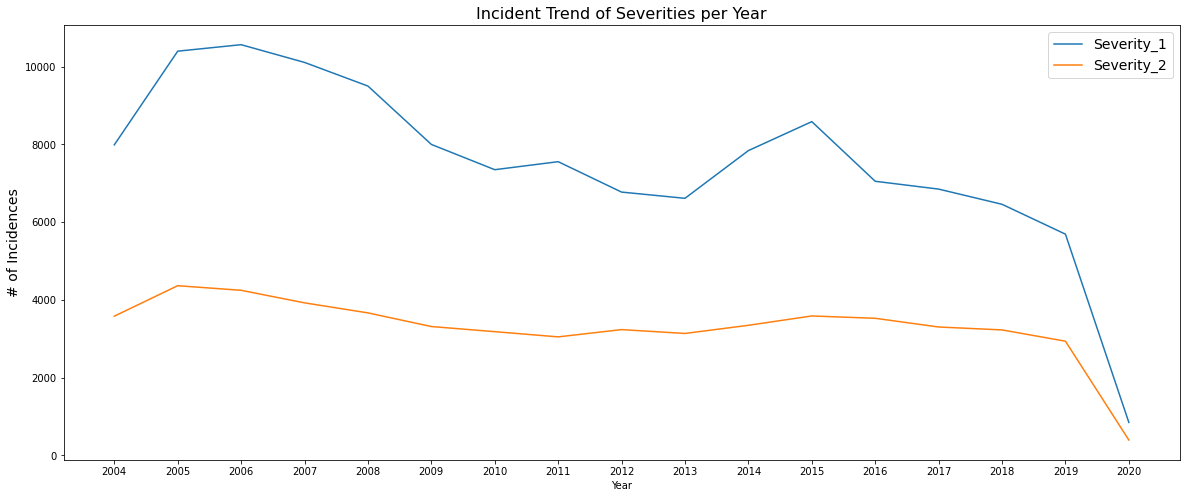

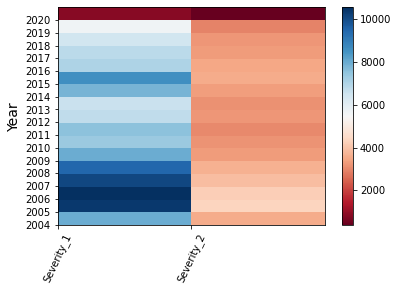

In [6]:
Period = 'Year'  #Period Can be 'Year','Month','Day','Hour'
Features = 'Severities' #Feature can be 'Weather' 'Road Conditions' 'Light Contidtions' 
                        #'Incident Features' 'Junction Type' 'Collision Type' 'Severities'
Title = "Incident Trend of "+Features+" per "+Period
df_temp = ExpDataSelect(Features, Period) #Call function ExpDataSelect with two inputs "Features", "Period"
LinePlot(df_temp, Period, Title)

##### figure 4.1.1 - 2 Casualty Trend by year<a name="figure411-2"></a>

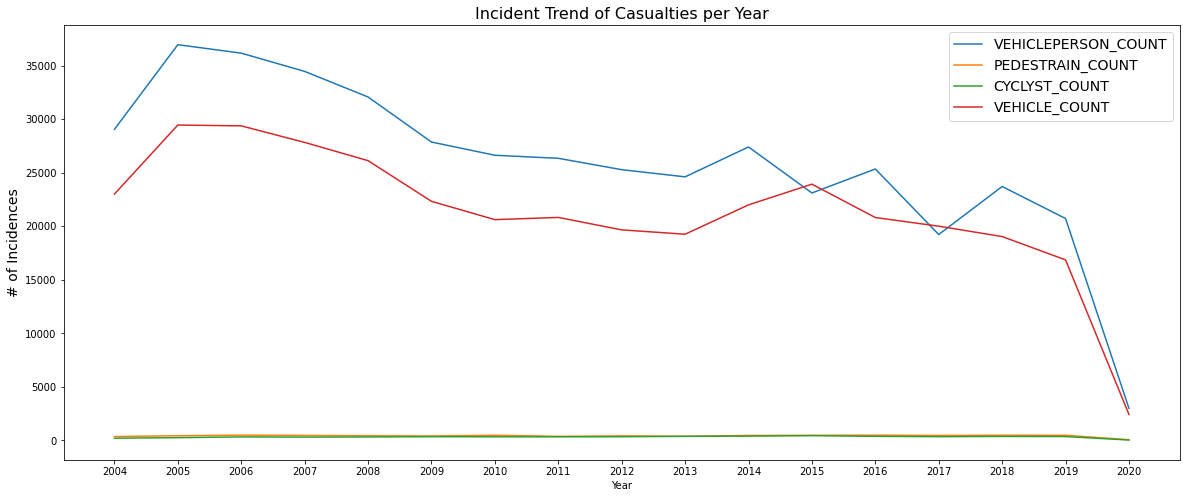

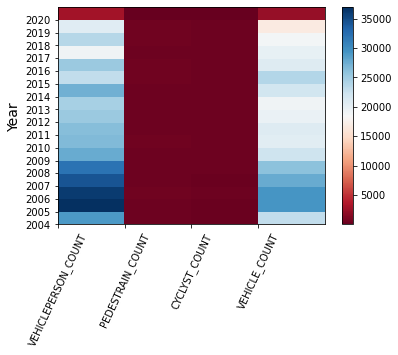

In [7]:
Period = 'Year'  #Can be 'Year','Month','Day','Hour'
Features = "Casualties"
Title = "Incident Trend of "+Features+" per "+Period
df_temp = ExpDataSelect(Features, Period)
LinePlot(df_temp, Period, Title)


##### figure 4.1.1 - 3 Incident Trend by Features by year <a name="figure411-3"></a>

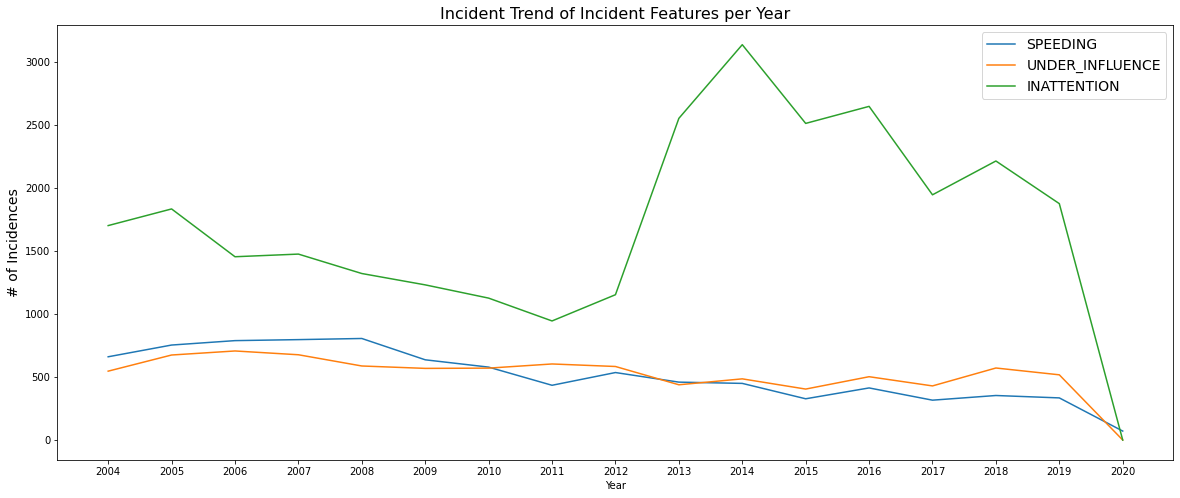

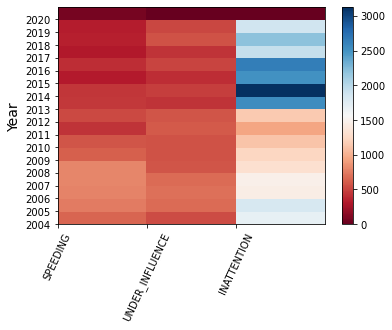

In [8]:
Period = 'Year'  #Can be 'Year','Month','Day','Hour'
Features = "Incident Features"
Title = "Incident Trend of "+Features+" per "+Period
df_temp = ExpDataSelect(Features, Period)
LinePlot(df_temp, Period, Title)

##### figure 4.1.1 - 4 Incident Trend by Collision Type by year <a name="figure411-4"></a>

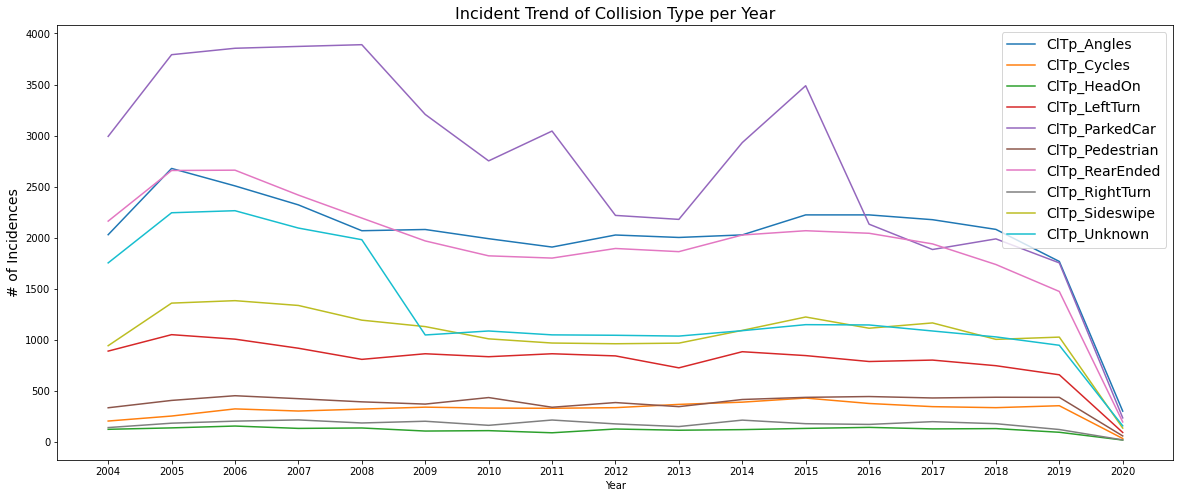

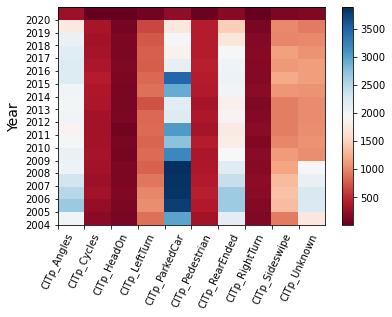

In [9]:
Period = 'Year'  #Can be 'Year','Month','Day','Hour'
Features = "Collision Type"
Title = "Incident Trend of "+Features+" per "+Period
df_temp = ExpDataSelect(Features, Period)
LinePlot(df_temp, Period, Title)

##### figure 4.1.1 - 5 Incident Trend by Junction Type by year <a name="figure411-5"></a>

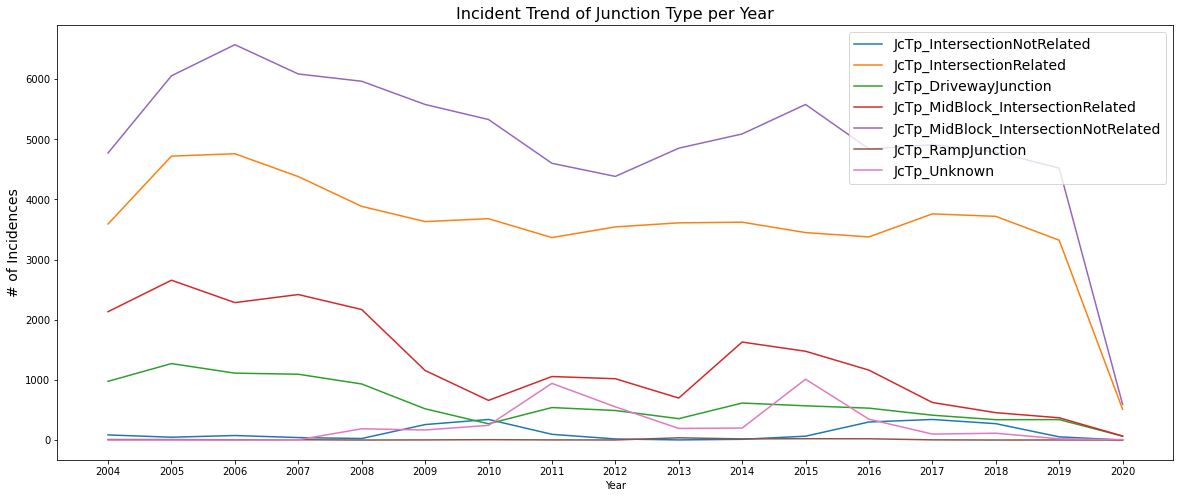

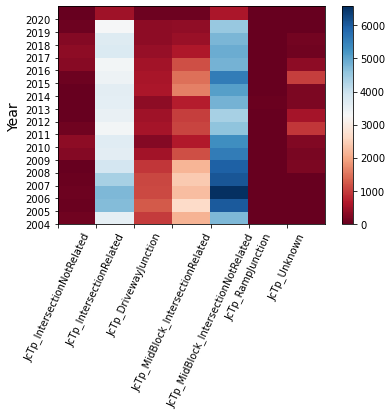

In [10]:
Period = 'Year'  #Can be 'Year','Month','Day','Hour'
Features = "Junction Type"
Title = "Incident Trend of "+Features+" per "+Period
df_temp = ExpDataSelect(Features, Period)
LinePlot(df_temp, Period, Title)

##### figure 4.1.1 - 6 Incident Trend by Weather by year <a name="figure411-6"></a>

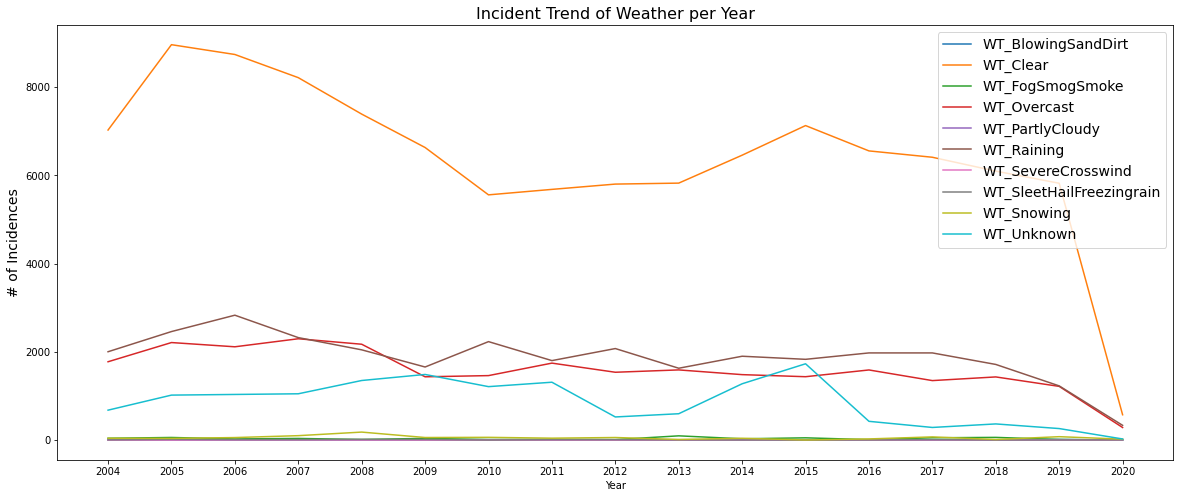

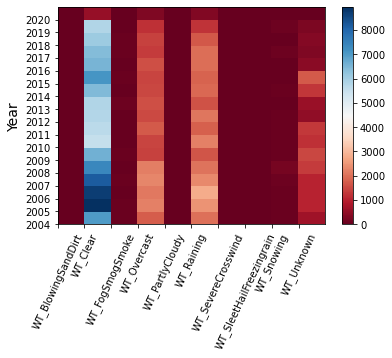

In [11]:
Period = 'Year'  #Can be 'Year','Month','Day','Hour'
Features = "Weather"
Title = "Incident Trend of "+Features+" per "+Period
df_temp = ExpDataSelect(Features, Period)
LinePlot(df_temp, Period, Title)

##### figure 4.1.1 - 7 Incident Trend by Road Condition by year <a name="figure411-7"></a>

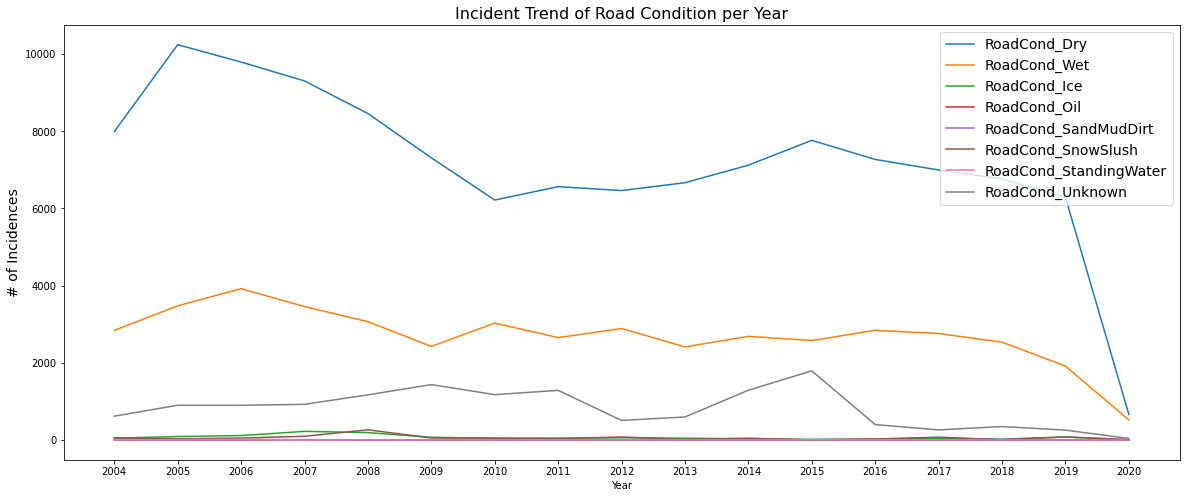

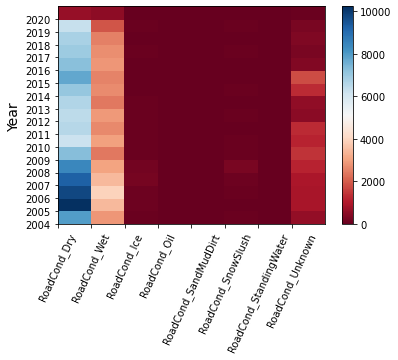

In [12]:
Period = 'Year'  #Can be 'Year','Month','Day','Hour'
Features = "Road Condition"
Title = "Incident Trend of "+Features+" per "+Period
df_temp = ExpDataSelect(Features, Period)
LinePlot(df_temp, Period, Title)

##### figure 4.1.1 - 8 Incident Trend by Light Condition by year <a name="figure411-8"></a>

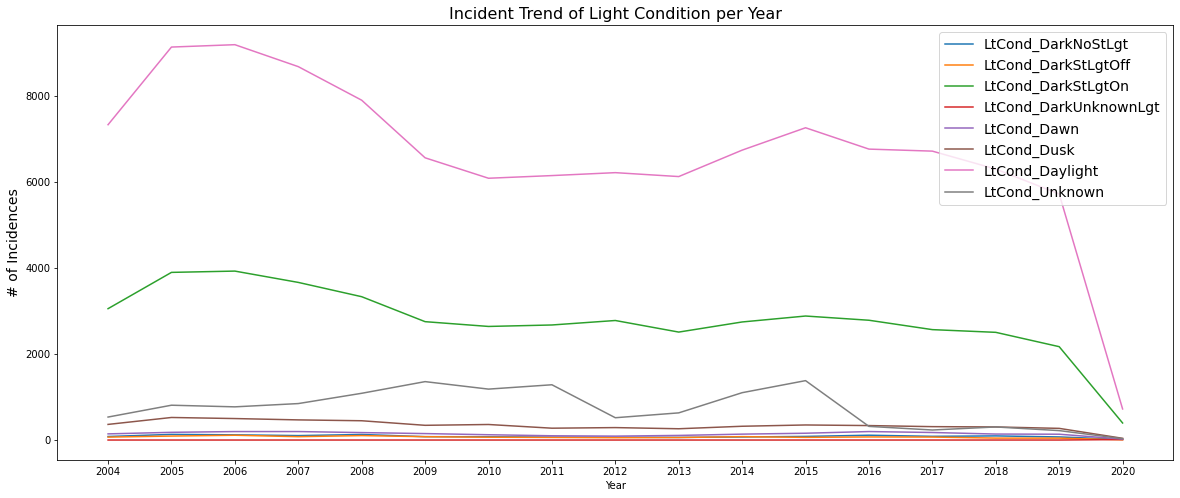

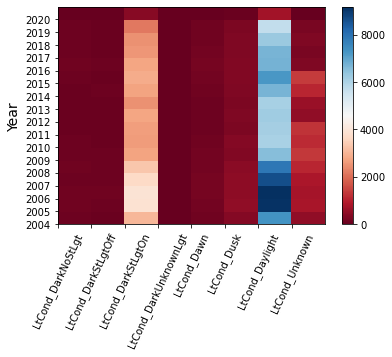

In [13]:
Period = 'Year'  #Can be 'Year','Month','Day','Hour'
Features = "Light Condition"
Title = "Incident Trend of "+Features+" per "+Period
df_temp = ExpDataSelect(Features, Period)
LinePlot(df_temp, Period, Title)

<p hidden>### 4.1.2 Time sensitive features (Weather, Road condition & Light Condition)<a name="Ex-analysis412"></a></p>

##### figure 4.1.2 - 9 Incident Trend of Weather per Month <a name="figure412-9"></a>

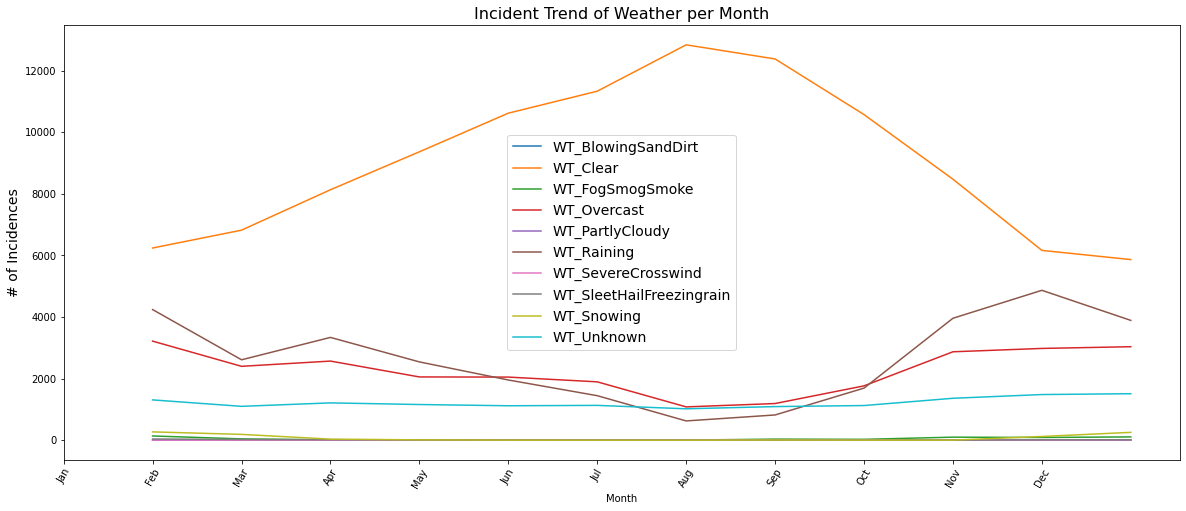

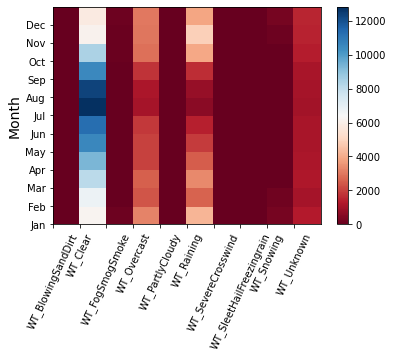

In [14]:
Period = 'Month'  #Can be 'Year','Month','Day','Hour'
Features = "Weather"
Title = "Incident Trend of "+Features+" per "+Period
df_temp = ExpDataSelect(Features, Period)
LinePlot(df_temp, Period, Title)

##### figure 4.1.2 - 9a Incident Trend of Weather per Month of Year <a name="figure412-9a"></a>

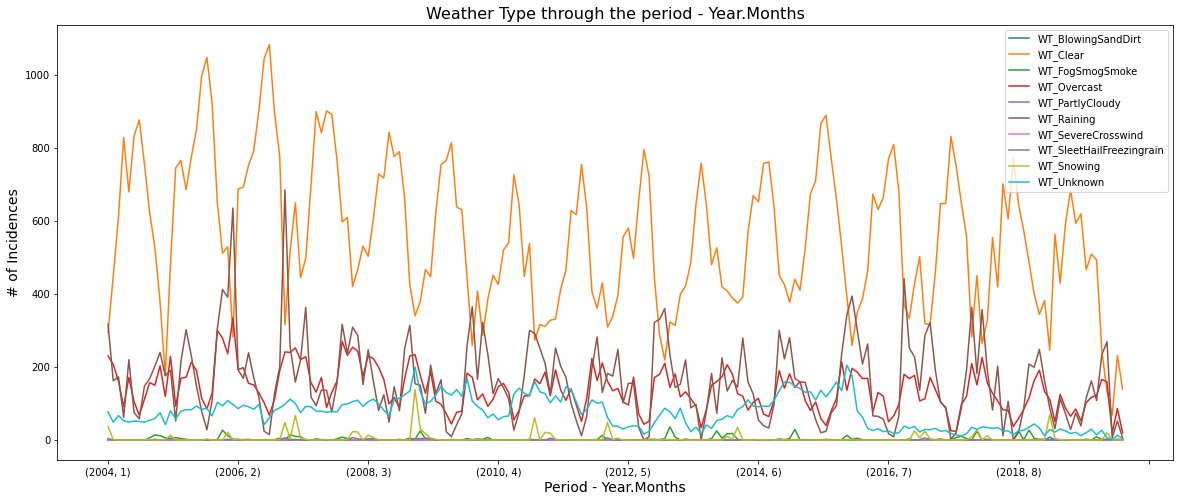

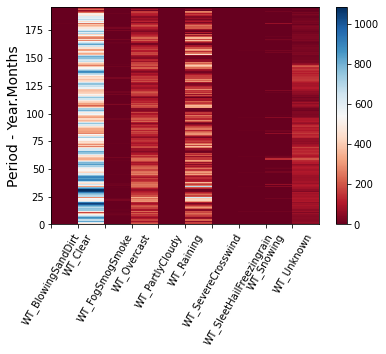

In [15]:
df_temp = df[['Year','Month','WT_BlowingSandDirt','WT_Clear','WT_FogSmogSmoke','WT_Overcast',
             'WT_PartlyCloudy','WT_Raining','WT_SevereCrosswind','WT_SleetHailFreezingrain','WT_Snowing','WT_Unknown']]
df_temp = df_temp.groupby(['Year','Month'], as_index = True).sum()

x = list(df_temp.columns.values)
y = list(df_temp.index.values)

df_temp.plot(kind='line',
       figsize = (20, 8),
       )
plt.title("Weather Type through the period - Year.Months", size = 16)
plt.xlabel("Period - Year.Months", size = 14)
plt.ylabel("# of Incidences", size = 14)
#plt.xticks(np.arange(df_temp.index.values.size), df_temp.index, rotation=0)
plt.legend(df_temp.columns.values)
plt.show()


plt.pcolor(df_temp, cmap = 'RdBu')
plt.ylabel("Period - Year.Months", size = 14)
#plt.yticks(np.arange(24), y, rotation=0)
plt.xticks(np.arange(df_temp.columns.values.size), x, rotation=60)
plt.colorbar()
plt.show()

##### figure 4.1.2 - 10 Incident Trend of Road Condition per Month <a name="figure412-10"></a>

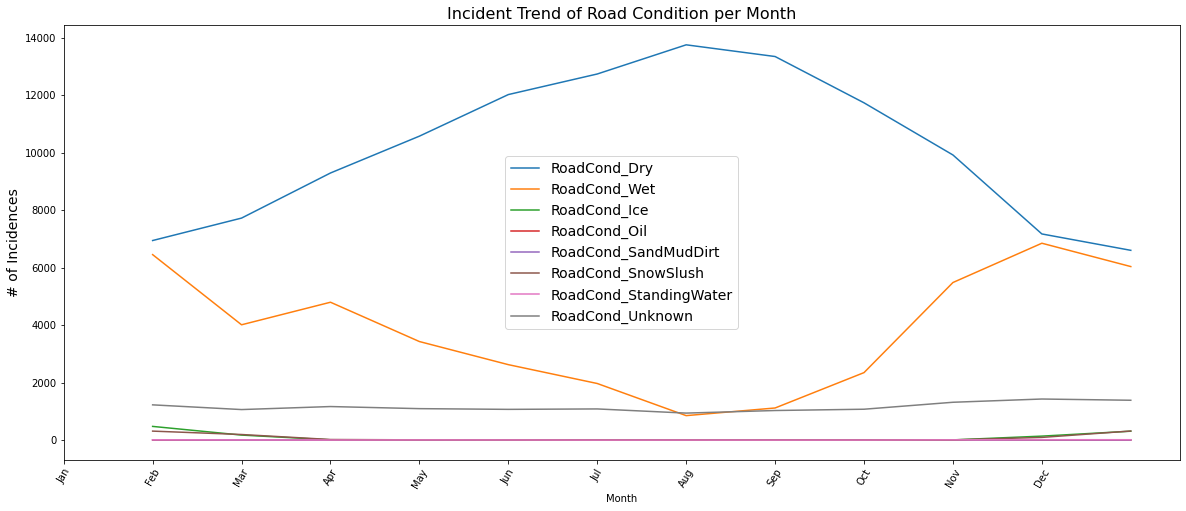

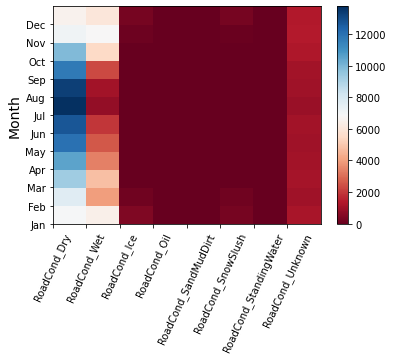

In [16]:
Period = 'Month'  #Can be 'Year','Month','Day','Hour'
Features = "Road Condition"
Title = "Incident Trend of "+Features+" per "+Period
df_temp = ExpDataSelect(Features, Period)
LinePlot(df_temp, Period, Title)

##### figure 4.1.2 - 11 Incident Trend of Light Condition per Month <a name="figure412-11"></a>

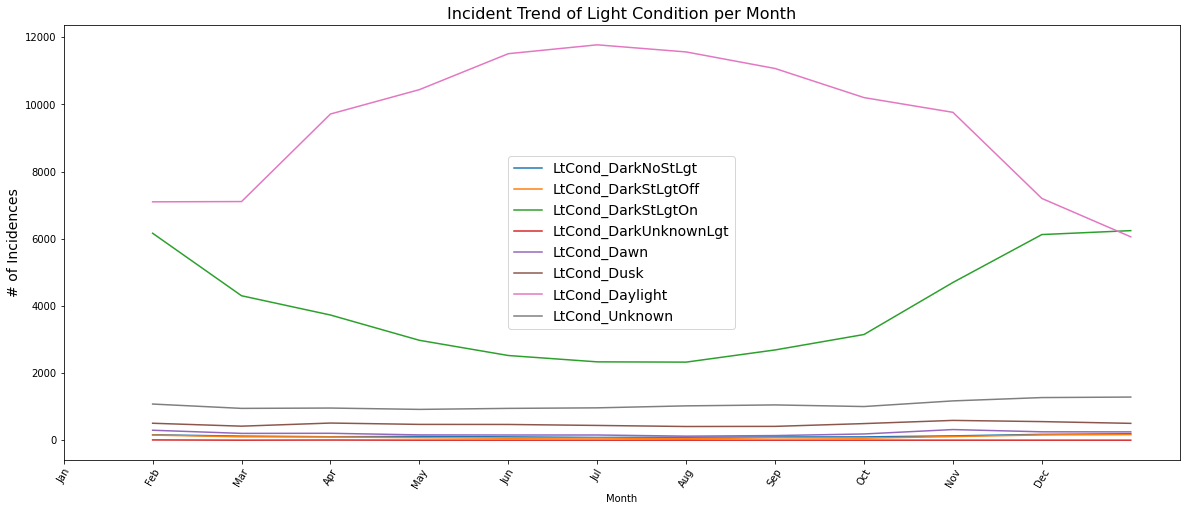

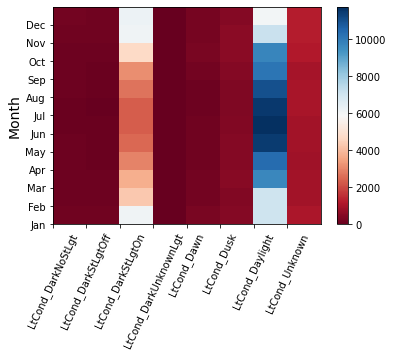

In [17]:
Period = 'Month'  #Can be 'Year','Month','Day','Hour'
Features = "Light Condition"
Title = "Incident Trend of "+Features+" per "+Period
df_temp = ExpDataSelect(Features, Period)
LinePlot(df_temp, Period, Title)

##### figure 4.1.2 - 12 Incident Trend of Light Condition per Hours <a name="figure412-12"></a>

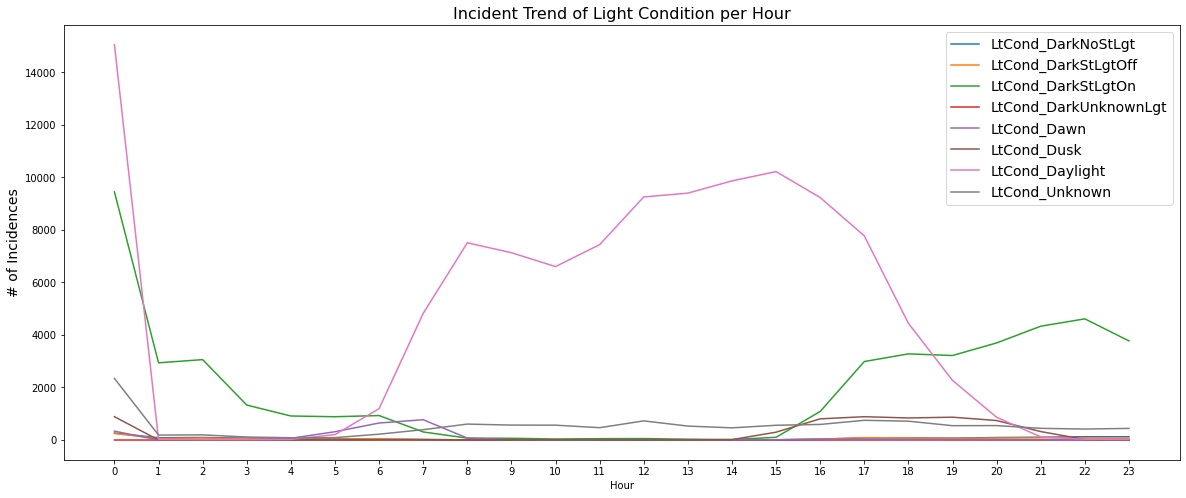

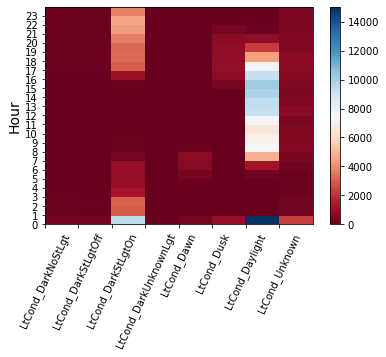

In [18]:
Period = 'Hour'  #Can be 'Year','Month','Day','Hour'
Features = "Light Condition"
Title = "Incident Trend of "+Features+" per "+Period
df_temp = ExpDataSelect(Features, Period)
LinePlot(df_temp, Period, Title)

##### figure 4.1.2 - 12a Incident Trend of Light Condition per Hours / Month <a name="figure412-12a"></a>

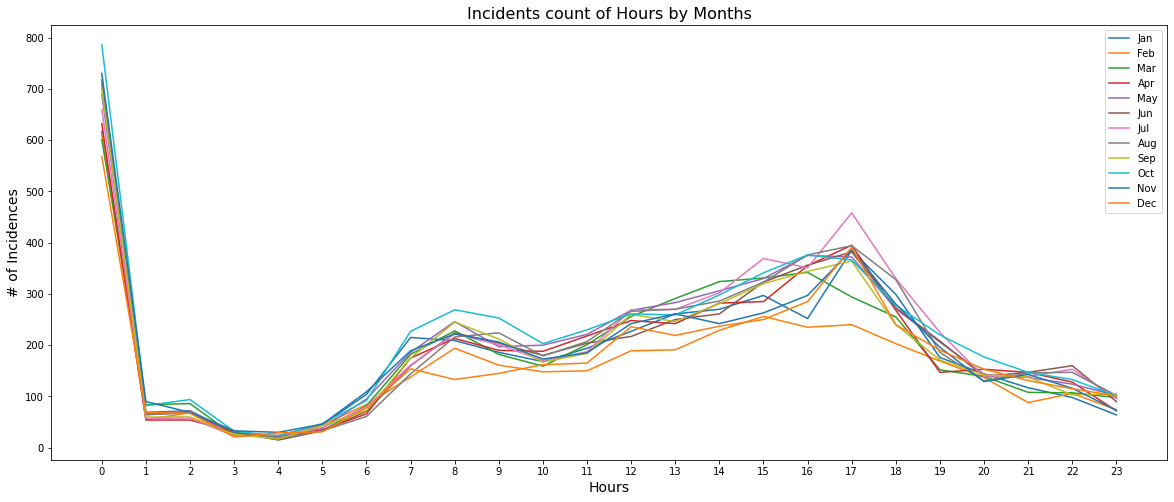

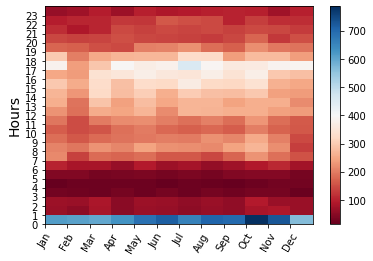

Severity_2                                                          \
Month         1      2      3      4      5      6      7      8      9    
Hour                                                                       
0          617.0  611.0  601.0  632.0  689.0  717.0  660.0  709.0  700.0   
1           69.0   55.0   84.0   54.0   67.0   65.0   57.0   64.0   60.0   
2           72.0   68.0   86.0   54.0   72.0   68.0   58.0   69.0   60.0   
3           29.0   25.0   24.0   31.0   23.0   31.0   23.0   33.0   26.0   
4           16.0   24.0   23.0   22.0   23.0   15.0   24.0   19.0   17.0   
5           45.0   45.0   33.0   35.0   38.0   33.0   39.0   33.0   43.0   
6          104.0   84.0   82.0   66.0   95.0   71.0   80.0   61.0   73.0   
7          215.0  138.0  182.0  175.0  186.0  160.0  161.0  144.0  175.0   
8          209.0  194.0  228.0  213.0  246.0  224.0  222.0  216.0  245.0   
9          186.0  161.0  182.0  190.0  197.0  204.0  201.0  224.0  212.0   
10         168.0  148.0  159.0  188.0  200.0  180.0  170.0  179.0  167.0   
11         194.0  150.0  201.0  218.0  221.0  204.0  187.0  207.0  184.0   
12         227.0  189.0  256.0  248.0  268.0  217.0  269.0  266.0  260.0   
13         261.0  191.0  291.0  242.0  283.0  250.0  270.0  270.0  246.0   
14         270.0  229.0  324.0  282.0  306.0  261.0  302.0  286.0  281.0   
15         297.0  256.0  331.0  285.0  330.0  323.0  369.0  323.0  320.0   
16         252.0  235.0  342.0  355.0  375.0  356.0  351.0  376.0  344.0   
17         385.0  240.0  294.0  395.0  372.0  382.0  458.0  394.0  364.0   
18         299.0  203.0  255.0  268.0  271.0  273.0  330.0  328.0  240.0   
19         176.0  169.0  152.0  147.0  206.0  208.0  225.0  186.0  171.0   
20         144.0  137.0  139.0  153.0  143.0  139.0  138.0  130.0  142.0   
21         117.0   88.0  108.0  147.0  137.0  147.0  139.0  146.0  138.0   
22          98.0  106.0  107.0  128.0  124.0  160.0  153.0  147.0  103.0   
23          64.0   74.0   98.0   72.0  102.0   90.0   96.0  102.0  105.0   

                            
Month     10     11     12  
Hour                        
0      786.0  730.0  568.0  
1       82.0   90.0   69.0  
2       94.0   69.0   67.0  
3       32.0   33.0   21.0  
4       23.0   30.0   29.0  
5       47.0   46.0   31.0  
6       92.0  109.0   78.0  
7      227.0  189.0  154.0  
8      269.0  222.0  133.0  
9      253.0  206.0  145.0  
10     203.0  173.0  162.0  
11     230.0  185.0  165.0  
12     261.0  242.0  236.0  
13     259.0  261.0  219.0  
14     298.0  242.0  237.0  
15     341.0  263.0  250.0  
16     376.0  297.0  285.0  
17     366.0  386.0  391.0  
18     278.0  280.0  240.0  
19     220.0  196.0  190.0  
20     177.0  129.0  153.0  
21     147.0  143.0  131.0  
22     133.0  116.0  115.0  
23     101.0   73.0  101.0

In [42]:
#--- Overall incidence trend through the same hour(s) of the period

df_temp = df_time[['Month','Hour','Severity_2']].groupby(['Month','Hour'], as_index = False).sum()
#df_temp.rename(columns={'X':""},inplace=True)
df_temp = df_temp.pivot(index = 'Hour', columns = 'Month')

x = list(df_temp.columns.values)
y = list(df_temp.index.values)

df_temp.plot(kind='line',
       figsize = (20, 8),
       )
plt.title("Incidents count of Hours by Months", size = 16)
plt.xlabel("Hours", size = 14)
plt.ylabel("# of Incidences", size = 14)
plt.xticks(np.arange(df_temp.index.values.size), df_temp.index, rotation=0)
plt.legend(calendar.month_abbr[1:13])
plt.show()


plt.pcolor(df_temp, cmap = 'RdBu')
plt.ylabel("Hours", size = 14)
plt.yticks(np.arange(24), y, rotation=0)
plt.xticks(np.arange(df_temp.columns.values.size), calendar.month_abbr[1:13], rotation=60)
plt.colorbar()
plt.show()

df_temp

<p hidden>### 4.1.3 Incident Catagorization & Distribution<a name="Ex-analysis413"></a></p>

##### figure 4.1.3 - 1 Incident Count x Weather <a name="figure413-1"></a>

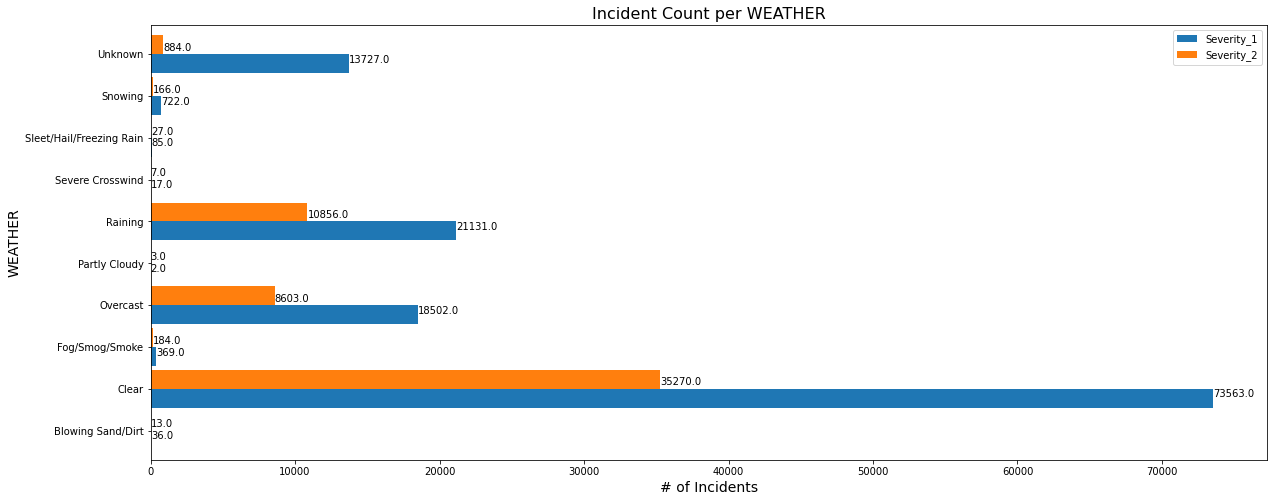

In [20]:
Feature = 'WEATHER'
Title = 'Incident Count per '+Feature
BarPlot_Severity(Feature,Title)

##### figure 4.1.3 - 2 Incident Count x Road Condition <a name="figure413-2"></a>

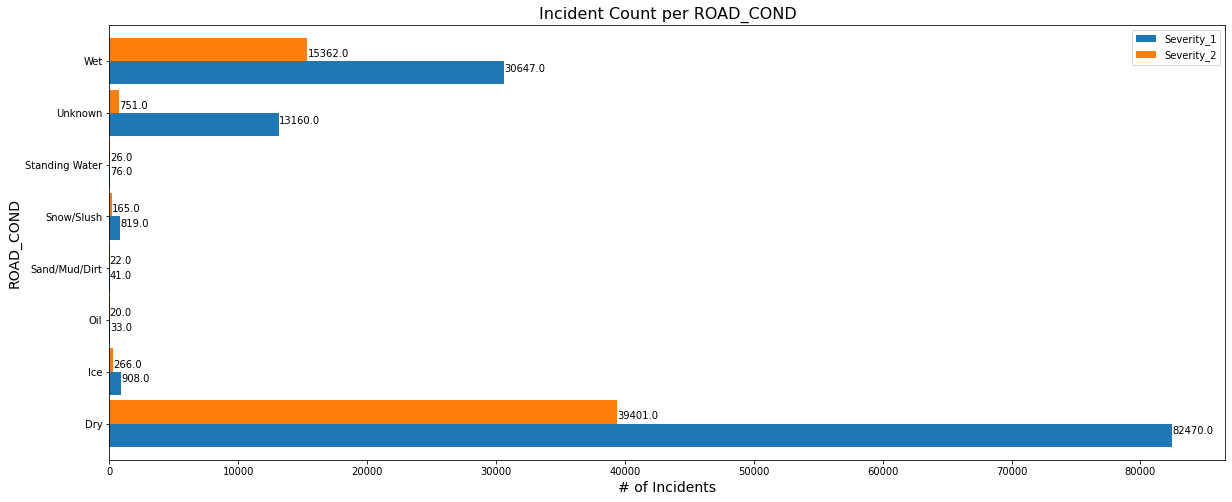

In [21]:
Feature = 'ROAD_COND'
Title = 'Incident Count per '+Feature
BarPlot_Severity(Feature,Title)

##### figure 4.1.3 - 3 Incident Count x Light Condition <a name="figure413-3"></a>

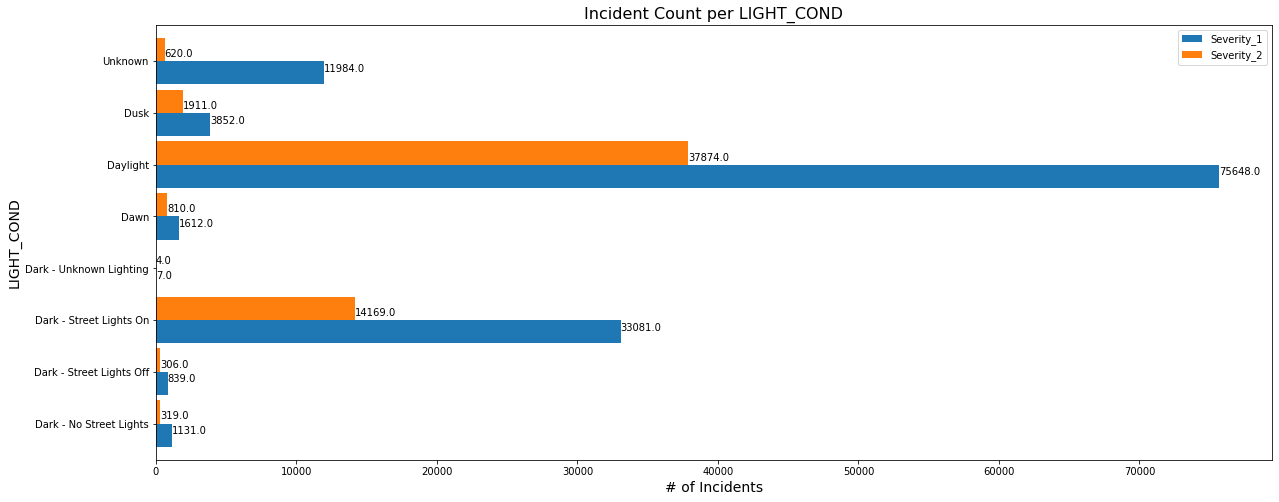

In [22]:
Feature = 'LIGHT_COND'
Title = 'Incident Count per '+Feature
BarPlot_Severity(Feature,Title)

  ##### figure 4.1.3 - 4 Incident Count x Collision Type <a name="figure413-4"></a>  

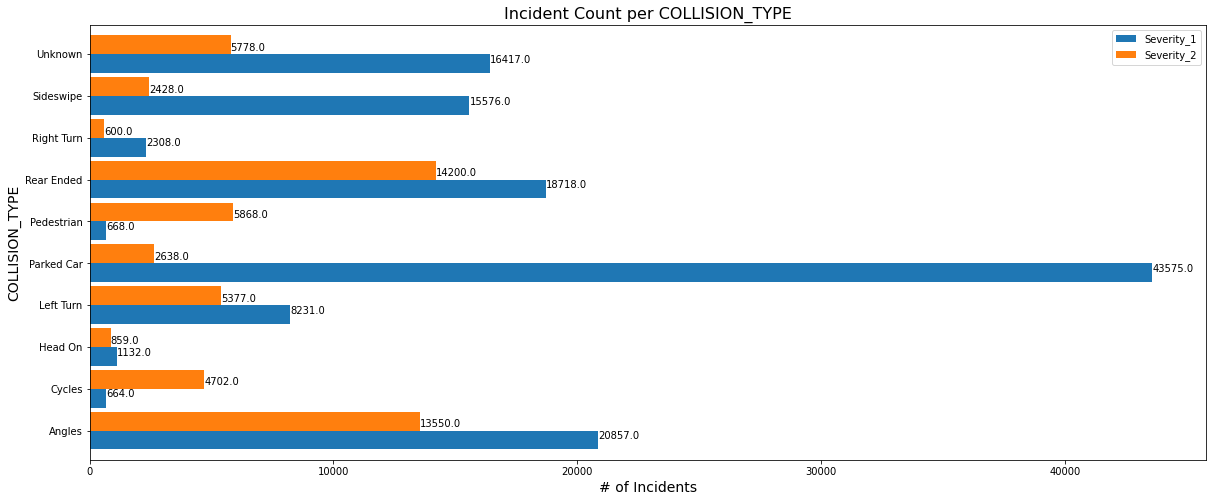

In [23]:
Feature = 'COLLISION_TYPE'
Title = 'Incident Count per '+Feature
BarPlot_Severity(Feature,Title)

  ##### figure 4.1.3 - 5 Incident Count x Junction Type <a name="figure413-5"></a>  

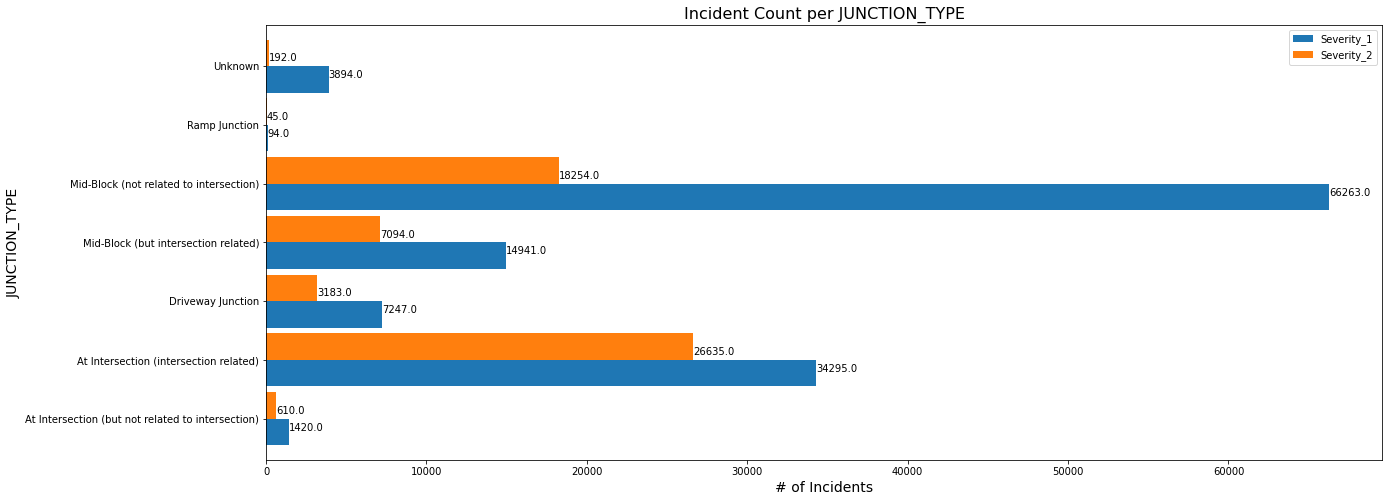

In [24]:
Feature = 'JUNCTION_TYPE'
Title = 'Incident Count per '+Feature
BarPlot_Severity(Feature,Title)

  ##### figure 4.1.3 - 6 Incident Count x Incident Feature <a name="figure413-6"></a>  

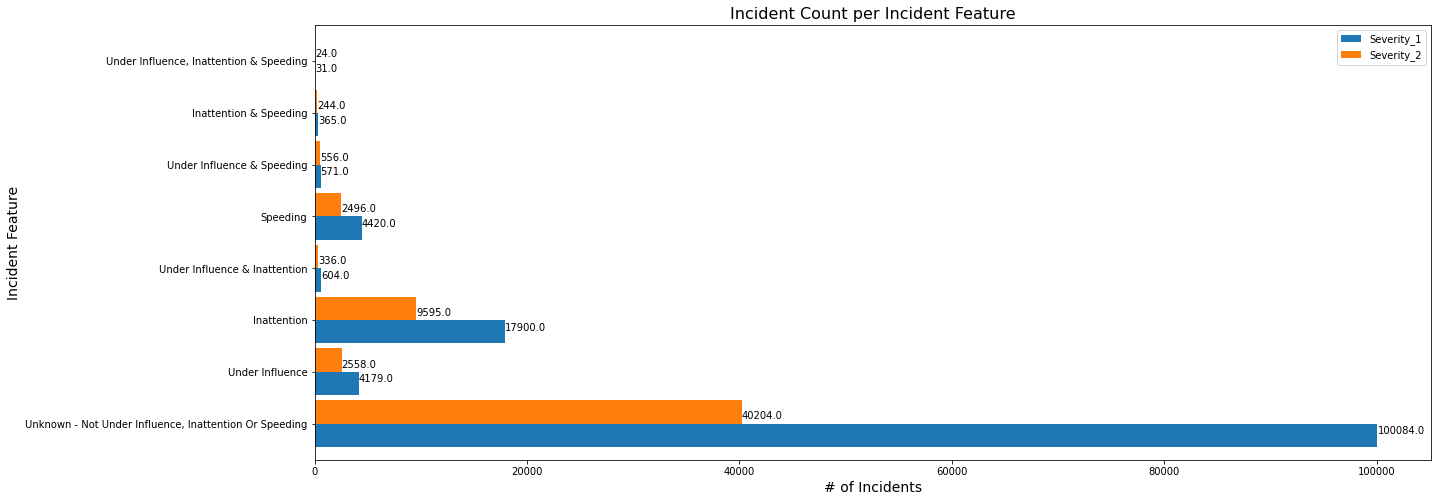

In [25]:
Feature = 'Incident Feature'
Title = 'Incident Count per '+Feature
BarPlot_Severity(Feature,Title)

 <p hidden> ### 4.1.4 Casualties  <a name="Ex-analysis414"></a>  </p>

  ##### figure 4.1.4 - 1 Casualty Analysis <a name="figure414-1"></a>  

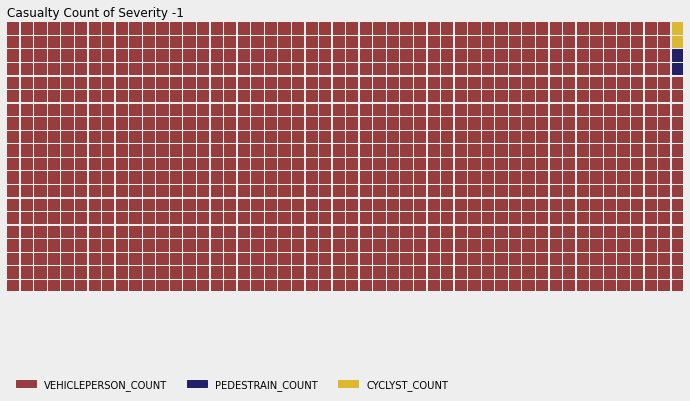

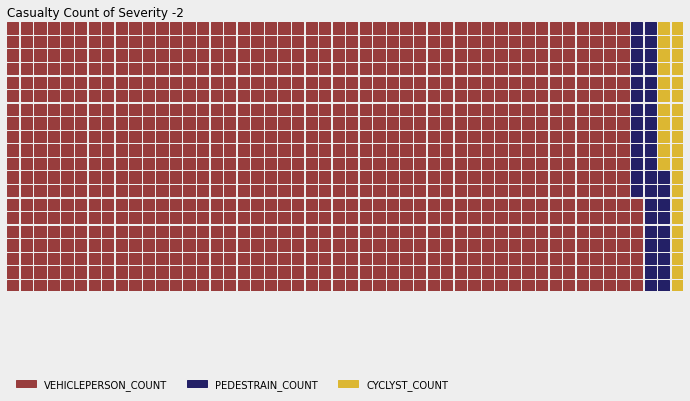

SEVERITY,1,2
VEHICLEPERSON_COUNT,995.40,926.46
PEDESTRAIN_COUNT,2.37,42.11
CYCLYST_COUNT,2.23,31.43


In [43]:
#Waffle chart analysis --- example: Casualties analysis --- person involved in car inciddent
Year = 'Avg' #Available 'Sum','Avg' or particular year from 2004~2020
df_casualty = df
#Step 1 - convert casualties into scaled portion instead of number **important while values are too large
if Year in range(2004,2020): #pick a certain year for analysis
    df_temp = df_casualty[df_casualty.INCIDENT_TIME.dt.year == Year][['VEHICLEPERSON_COUNT','PEDESTRAIN_COUNT','CYCLYST_COUNT','SEVERITY']]
    df_temp = df_temp.groupby(['SEVERITY'], as_index = True).sum()
elif Year == 'Avg': #average the number by years
    df_temp = df_casualty[['VEHICLEPERSON_COUNT','PEDESTRAIN_COUNT','CYCLYST_COUNT','SEVERITY']]
    period = df_casualty.groupby(['Year'], as_index = True).count()
    period = period.index.size
    df_temp = df_temp.groupby(['SEVERITY'], as_index = True).sum()/period

elif Year == 'Sum': #average the number by years
    df_temp = df_casualty[['VEHICLEPERSON_COUNT','PEDESTRAIN_COUNT','CYCLYST_COUNT','SEVERITY']]
    df_temp = df_temp.groupby(['SEVERITY'], as_index = True).sum()

df_temp = df_temp.T
df_temp = (1000*(df_temp/df_temp.sum())).round(2)

#Step 2 - Display the waffle plot
for i in df_temp.columns.values:
        data = df_temp[i].values

        fig = plt.figure(
            FigureClass=Waffle,
            figsize = (100, 6),
            rows=20, 
            values=data, 
            colors=("#983D3D", "#232066", "#DCB732"),
            title={'label': 'Casualty Count of Severity -'+str(i), 'loc': 'left'},
            labels=["{0}".format(v) for v in df_temp.index.values],
            legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0}
        )
        fig.gca().set_facecolor('#EEEEEE')
        fig.set_facecolor('#EEEEEE')
        plt.show() 

df_temp


 <p hidden> ### 4.1.5 Geographical Distributions  - "Seattle got LEGAL WEEDS"<a name="Ex-analysis415"></a>  </p>

  ##### figure 4.1.5 - 1 Map exploration <a name="figure415"></a>  

In [27]:
#---Showing where did incidents happen---
SEVERITY = 2 #here we use 'SEVERITY' as the target, available values 1, 2
Year = 2014
Feature = 'Inattention' #Available options "Road Conditin","Speeding", "Inattention"
Enabler = 1 #Enabler options availabe as values of the feature, i.e. SPEEDING 0 = No, 1 = Yes;  ROAD_COND: Dry, Wet etc.
#We can have other options

#Pinpoint certain featured incidence of a certain time (*Warning, please limite the dataset size)
if Feature == 'Road Condition':
    df_map = df_time[df_time.ROAD_COND == Enabler][df_time.Year == Year][df_time.SEVERITY == SEVERITY]
if Feature == 'Weather':
    df_map = df_time[df_time.WEATHER == Enabler][df_time.Year == Year][df_time.SEVERITY == SEVERITY]
if Feature == 'Speeding':
    df_map = df_time[df_time.SPEEDING == Enabler][df_time.Year == Year][df_time.SEVERITY == SEVERITY]
if Feature == 'Inattention':
    df_map = df_time[df_time.INATTENTION == Enabler][df_time.Year == Year][df_time.SEVERITY == SEVERITY] 

#df_speeding_map.info()
df_map.reset_index(drop=True, inplace=True)
print('Records filtered for Severity-'+str(SEVERITY)+' incidents in '+str(Year)+' "'+Feature+'='+str(Enabler)+'" is '+str(df_map.size))
locations = df_map[['Y','X']]
locationlist = locations.values.tolist()

Seattle_map_incident = folium.Map(location=[47.609722, -122.333056],zoom_start=12)

for point in range(0, len(locationlist)):
    #print(df_speeding_map[point])
    #try:
    folium.Marker(locationlist[point], popup = df_map['SEVERITY'][point]).add_to(Seattle_map_incident)


Seattle_map_incident

<ipython-input-27-095b41f66509>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_map = df_time[df_time.INATTENTION == Enabler][df_time.Year == Year][df_time.SEVERITY == SEVERITY]
<ipython-input-27-095b41f66509>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_map = df_time[df_time.INATTENTION == Enabler][df_time.Year == Year][df_time.SEVERITY == SEVERITY]


Records filtered for Severity-2 incidents in 2014 "Inattention=1" is 71757


## 4.2 Modeling & Evaluation <a name="Model-Eva"></a>

### 4.2.1 [Preparing for Modeling - Selection of Data](#Model_Eva421)
Traffic incidents occured with certain cause factors, and also with random probability.  The choice of independent features in this case, is by comparing the data plots (Regression and Residual plot) to identify the relatively suitable candidates for linear regression modeling.

In this case, we try to build the model around "Junction Type" against "Severity 2" incident.  As we see relatively consistant pattern from hourly incidence count, the data sampling span is set to be "Hour" (24 hours).

By browsing through the [data regression/residual plots](#figure421-1), "jcTp_MidBlock_IntersectionRelated" seems to be a suitable candidate.  This junction type was also identified to be one significant contributor of Severity 2 incidents during the [exploratory analysis](#figure413).

### 4.2.2 [Fit, Traning and Evaluation the models](#Model_Eva422)

<u><b>[Simple Linear Regression](#Model_Eva4221)</b></u><br>

text

<u><b>[PolyNormial Transformation + Linear Regression](#Model_Eva4222)</b></u><br>

text

<u><b>[PolyNormial Transformation + Ridge Regression](#Model_Eva4223)</b></u><br>

text

<u><b>[Grid CV](#Model_Eva4224)</b></u><br>

text


### 4.2.3 Compare and select the model


                | Simple LR | PolyNorm LR | Ridge Reg. | Grid CV
                              Ordre: 3     Apha: 14.3k
------------------------------------------------------------------------
- Cross Val Eva
                | 0.572 | 0.572 | 0.590 | 0.589
                | 0.572 | 0.572 | 0.570 | 0.570
                | 0.748 | 0.749 | 0.748 | 0.748
------------------------------------------------------------------------
- Training R^2
                | 0.988 | 0.989 | 0.988 | 0.988
------------------------------------------------------------------------
- Testing R^2
                | 0.438 | -25.825 | 0.988 | 0.451
------------------------------------------------------------------------
- MSE
                | 2190k | 104562k | 49.6k | 2140k
------------------------------------------------------------------------


In [49]:
#Machine learning part --- number of Severity 1 incidence associate to the 
#cause of the inidence (speeding/impaired driving/inattention) OR environment (weathter/road/light) OR incidence types
#Trending along the years / months / days / hours
lm = LinearRegression()

#df_temp = pd.DataFrame({'Remark' : []})
df_ml = df
    
def DataSetSelect(measurement,independent_features,target_feature):
    df_temp = df_ml

    #---Selection of analysis scheme
    if measurement == 'Years':
        df_temp[measurement] = df_ml['INCIDENT_TIME'].dt.year
    elif measurement == 'Months':
        df_temp[measurement] = df_ml['INCIDENT_TIME'].dt.month
    elif measurement == 'Days':
        df_temp[measurement] = df_ml['INCIDENT_TIME'].dt.date
    elif measurement == 'Hours':
        df_temp[measurement] = df_ml['INCIDENT_TIME'].dt.hour
    else:
        print("Only available measurements are: Year, Months, Days, Hours")
        return None
   
    df_temp = df_temp.groupby([measurement], as_index = True).sum()

    if independent_features == 'Weather':
        X = df_temp[['WT_BlowingSandDirt','WT_Clear','WT_FogSmogSmoke','WT_Overcast',
                    'WT_PartlyCloudy','WT_Raining','WT_SevereCrosswind','WT_SleetHailFreezingrain',
                    'WT_Snowing','WT_Unknown']]
    if independent_features == 'Road Condition':
        X = df_temp[['RoadCond_Dry','RoadCond_Wet','RoadCond_Ice','RoadCond_Oil',
                    'RoadCond_SandMudDirt','RoadCond_SnowSlush','RoadCond_StandingWater','RoadCond_Unknown']]
    if independent_features == 'Light Condition':
        X = df_temp[['LtCond_DarkNoStLgt','LtCond_DarkStLgtOff','LtCond_DarkStLgtOn','LtCond_DarkUnknownLgt',
                    'LtCond_Dawn','LtCond_Dusk','LtCond_Daylight','LtCond_Unknown']]
    if independent_features == 'Incident Features':
        X = df_temp[['SPEEDING','UNDER_INFLUENCE','INATTENTION']] 
    if independent_features == 'Junction Type':
        X = df_temp[['JcTp_IntersectionNotRelated','JcTp_IntersectionRelated','JcTp_DrivewayJunction',
                    'JcTp_MidBlock_IntersectionRelated','JcTp_MidBlock_IntersectionNotRelated',
                    'JcTp_RampJunction','JcTp_Unknown']]
    if independent_features == 'Collision Type':
        X = df_temp[['ClTp_Angles','ClTp_Cycles','ClTp_HeadOn','ClTp_LeftTurn','ClTp_ParkedCar',
                    'ClTp_Pedestrian','ClTp_RearEnded','ClTp_RightTurn','ClTp_Sideswipe','ClTp_Unknown']]
    if independent_features == 'Casualties':
        X = df_temp[[measurement,'VEHICLEPERSON_COUNT','PEDESTRAIN_COUNT','CYCLYST_COUNT','VEHICLE_COUNT']]
  
    if target_feature == 'Severity_1' or target_feature == 'Severity_2' or target_feature == 'PERSON_COUNT':
        y = df_temp[[target_feature]]
       
    return X,y,df_temp

def DistributionPlot(ActualVal, PredictedVal, Title, figW = 20, figH = 8):
    plt.figure(figsize=(figW, figH))
    ax1 = sns.distplot(ActualVal, hist=True, color="r", label="Actual")
    ax2 = sns.distplot(PredictedVal, hist=True, color="b", label="Predict", ax=ax1)
    plt.title(Title)
    #plt.title('Distribution Plot -  ' + X + ' relate to '+target_feature+' @'+measurement')
    plt.xlabel('# of Incident')
    plt.ylabel('Proportion of scenario')
    plt.legend(['Actual','Predict'])
    plt.show()
    plt.close()    
    
def RegressionPlot(X,Features,target_feature,measurement,df_temp):
    #for values in X:
    #    sns.regplot(x=values, y=target_feature, data=df_temp)
    sns.regplot(x=X, y=target_feature, data=df_temp)
    plt.title('Regression Plot - ' + X + ' relate to '+target_feature+' @'+measurement)
    plt.xlabel('# of Incidents by Features')
    plt.ylabel('# of Incidents by Independent Vars')
    #plt.legend(['Actual','Predict'])
    plt.show()

def ResidualPlot(X,Features,target_feature,measurement,df_temp):
   # for values in X:
   #     sns.residplot(df_temp[values], df_temp[target_feature])
        
    sns.residplot(df_temp[X], df_temp[target_feature])

    plt.title('Residual Plot - ' + X + ' relate to '+target_feature+' @'+measurement)
    #plt.legend(X)
    plt.show()
    
def ModelEvaluation(Model, X, y, X_train, X_test, y_train, y_test, y_hat):
    #Evaluation of the model
    print("Predicted values:", y_hat[0:4])
    print("True values:", y_test[0:4].values)
    print("Cross Validation Score = "+str(cross_val_score(Model, X, y, cv=3)))
    print("Train R^2 = "+str(Model.score(X_train,y_train)))
    print("Test R^2 = "+str(Model.score(X_test,y_test)))
    print("MSE = "+str(mean_squared_error(y_test, y_hat))) 

def PollyPlot(xtrain, xtest, y_train, y_test, LR,Poly, figW = 20, figH =8):
    plt.figure(figsize=(figW, figH))
      
    #training data 
    #testing data 
    # lr:  linear regression object 
    #poly_transform:  polynomial transformation object 
 
    xmax=max([xtrain.values.max(), xtest.values.max()])

    xmin=min([xtrain.values.min(), xtest.values.min()])

    x=np.arange(xmin, xmax, 0.1)


    plt.plot(xtrain, y_train, 'ro', label='Training Data')
    plt.plot(xtest, y_test, 'go', label='Test Data')
    plt.plot(x, LR.predict(Poly.fit_transform(x.reshape(-1, 1))), label='Predicted Function')
    plt.ylim([-10000, 60000])
    plt.ylabel('Case Count')
    plt.legend()
    plt.show()
    
def TrainTestSplit(X,y,size,randomness):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=randomness)
    print("number of test samples :", X_test.shape[0])
    print("number of training samples:",X_train.shape[0])
    return X_train, X_test, y_train, y_test

<p hidden>### 4.2.1 Preparing for Modeling & Selection of Data<a name="Model_Eva421"></a></p>

#### 4.2.1-1 Figure - data regression/residual plot <a name="figure421-1"></a>

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 23
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   JcTp_IntersectionNotRelated           24 non-null     float64
 1   JcTp_IntersectionRelated              24 non-null     float64
 2   JcTp_DrivewayJunction                 24 non-null     float64
 3   JcTp_MidBlock_IntersectionRelated     24 non-null     float64
 4   JcTp_MidBlock_IntersectionNotRelated  24 non-null     float64
 5   JcTp_RampJunction                     24 non-null     float64
 6   JcTp_Unknown                          24 non-null     float64
dtypes: float64(7)
memory usage: 1.5 KB


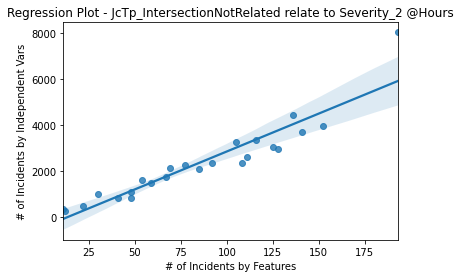

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


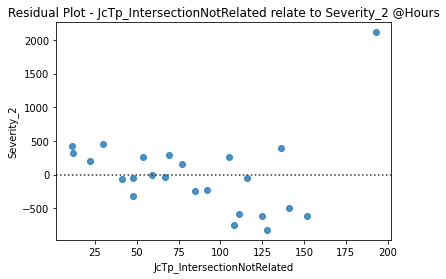

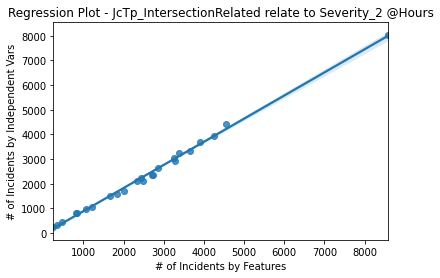

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


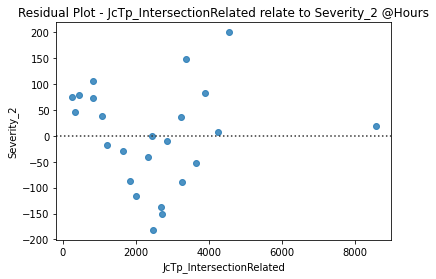

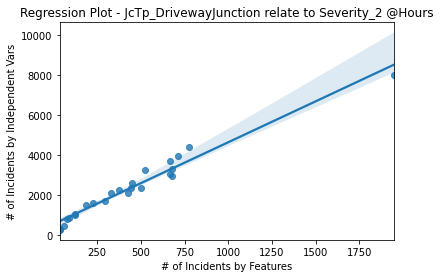

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


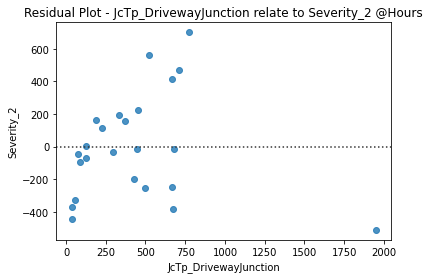

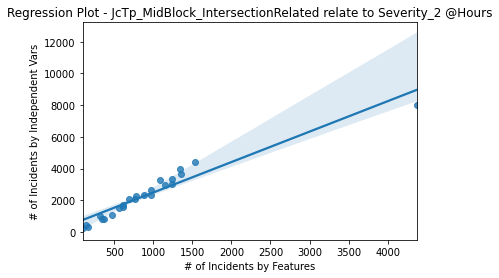

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


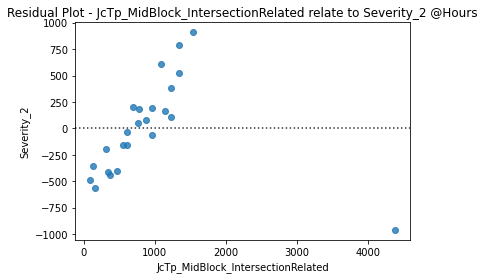

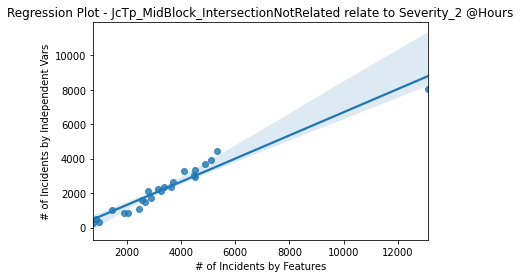

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


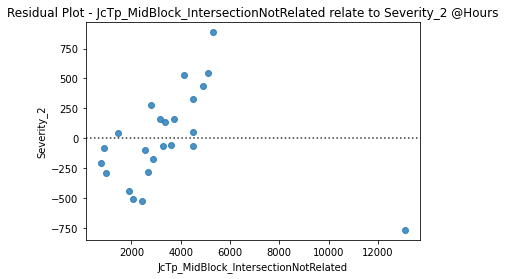

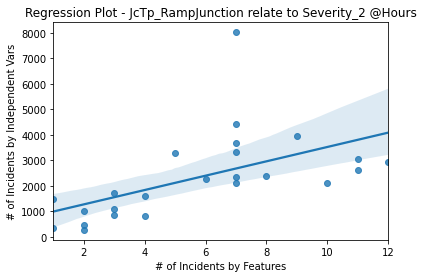

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


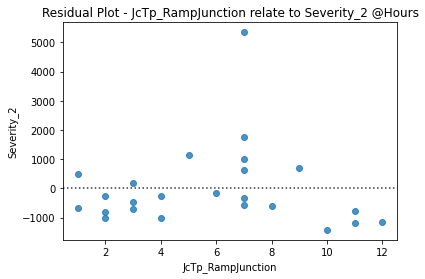

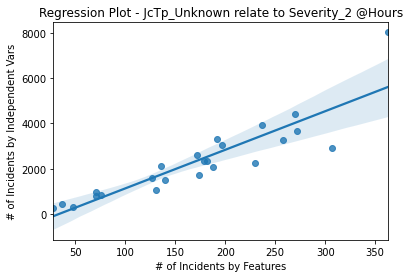

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


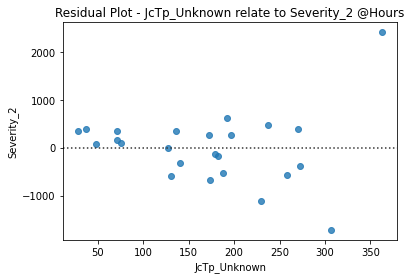

In [47]:
Period = 'Hours'
Features = 'Junction Type'
Target = 'Severity_2'

X_Features, y, df_temp = DataSetSelect(Period,Features,Target) #Call Func per seleted scenario
X_Features.info()

for x in X_Features.columns.values:
    RegressionPlot(x,Features,Target,Period,df_temp)
    ResidualPlot(x,Features,Target,Period,df_temp)

#Compare the Regression and Residual Plots in features of X, select the best feature for further analysis
#i.e. WT_Raining days associated Severity 2 Incident is relatively the best candidate among other Weathers

<p hidden>### 4.2.2 Fit, Traning and Evaluation the models <a name="Model_Eva422"></a></p>

#### 4.2.2.1 Simple Linear Regression & Evaluation<a name="Model_Eva4221"></a>

number of test samples : 8
number of training samples: 16
Predicted values: [[ 2651.15552492]
 [ 3712.41711082]
 [12163.51330932]
 [ 2982.62567905]]
True values: [[2621.]
 [3944.]
 [8020.]
 [3265.]]
Cross Validation Score = [0.57234358 0.57152581 0.74871677]
Train R^2 = 0.9881733216098151
Test R^2 = 0.4379158047032776
MSE = 2190969.9061307106


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


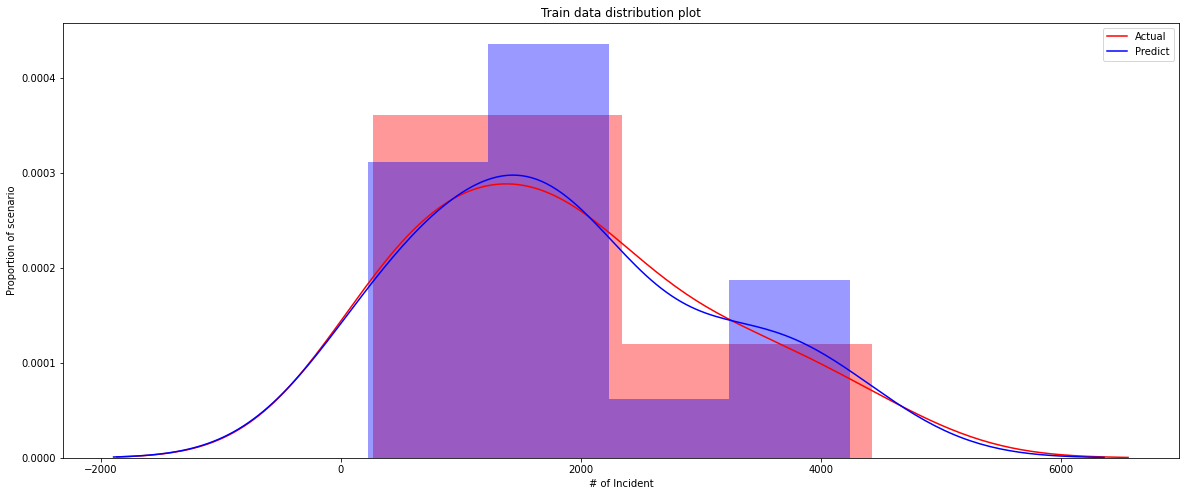

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


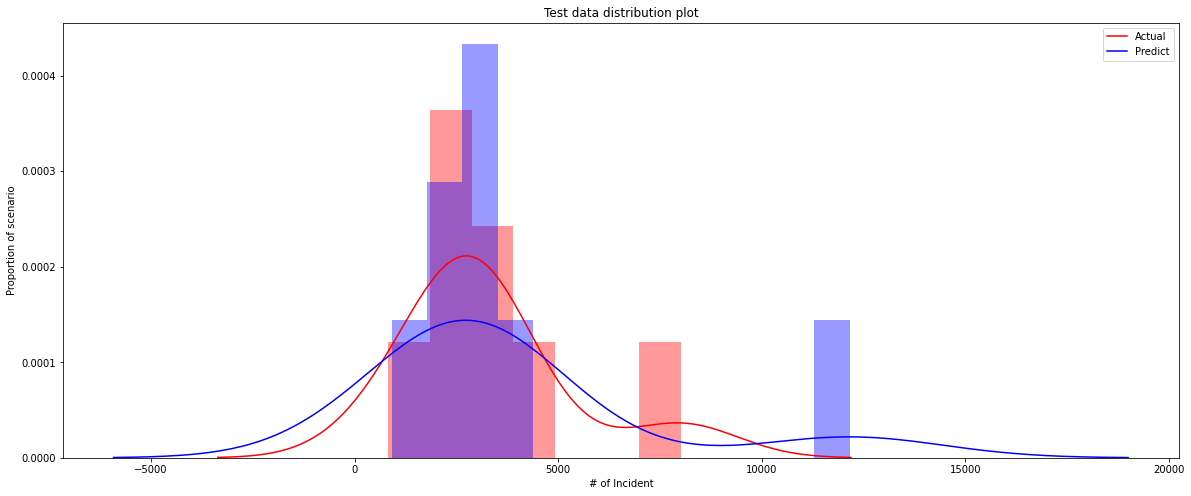

In [50]:
#Simple Linear Regression & Evaluation
lr = LinearRegression()

X = X_Features[['JcTp_MidBlock_IntersectionRelated']]
X_train, X_test, y_train, y_test = TrainTestSplit(X,y,0.33,42)

lr.fit(X_train,y_train)
y_hat = lr.predict(X_test)
y_hat_train = lr.predict(X_train)

ModelEvaluation(lr, X, y, X_train, X_test, y_train, y_test, y_hat)

DistributionPlot(y_train, y_hat_train, 'Train data distribution plot')
DistributionPlot(y_test, y_hat, 'Test data distribution plot')

#### 4.2.2.2 PolyNormial Transformation + Linear Regression <a name="Model_Eva4222"></a>

Text(0.5, 1.0, 'R^2 Using Test Data')

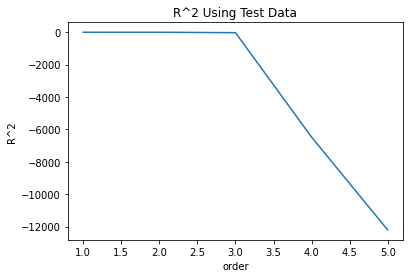

In [31]:
#Polynomial LR and model evaluation

#Evaluate the best order for Polynomial
Rsqu_test = []

order = [1,2,3,4,5]
for n in order:
    pr = PolynomialFeatures(degree=n)
    X_train_pr = pr.fit_transform(X_train)
    X_test_pr = pr.fit_transform(X_test)
    lr.fit(X_train_pr, y_train)
    Rsqu_test.append(lr.score(X_test_pr, y_test))

plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')

Predicted values: [[ 2583.74016969]
 [ 3706.74943988]
 [36936.32438589]
 [ 2913.00422919]]
True values: [[2621.]
 [3944.]
 [8020.]
 [3265.]]
Cross Validation Score = [0.57234358 0.57152581 0.74871677]
Train R^2 = 0.9893898147649006
Test R^2 = -25.824952900891123
MSE = 104562030.08554664


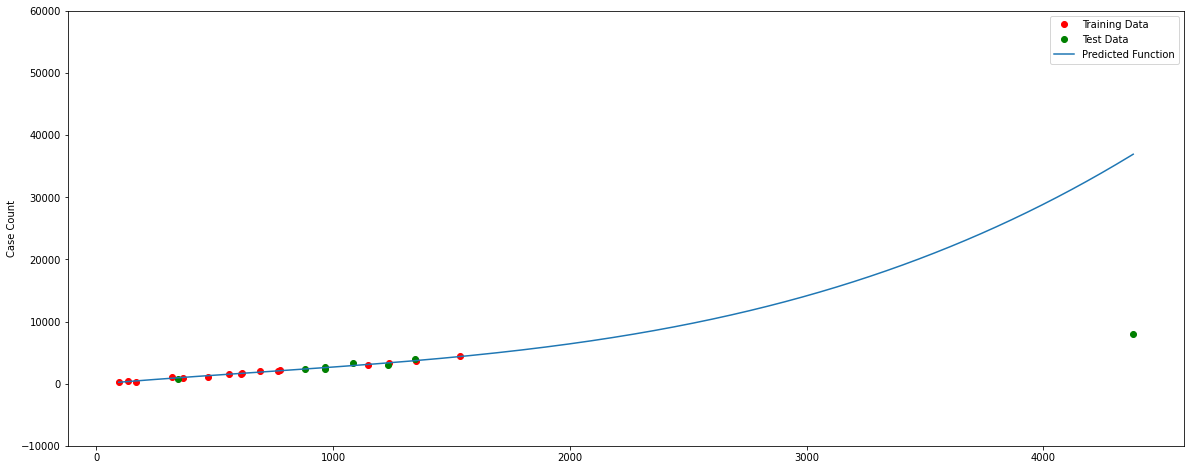

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


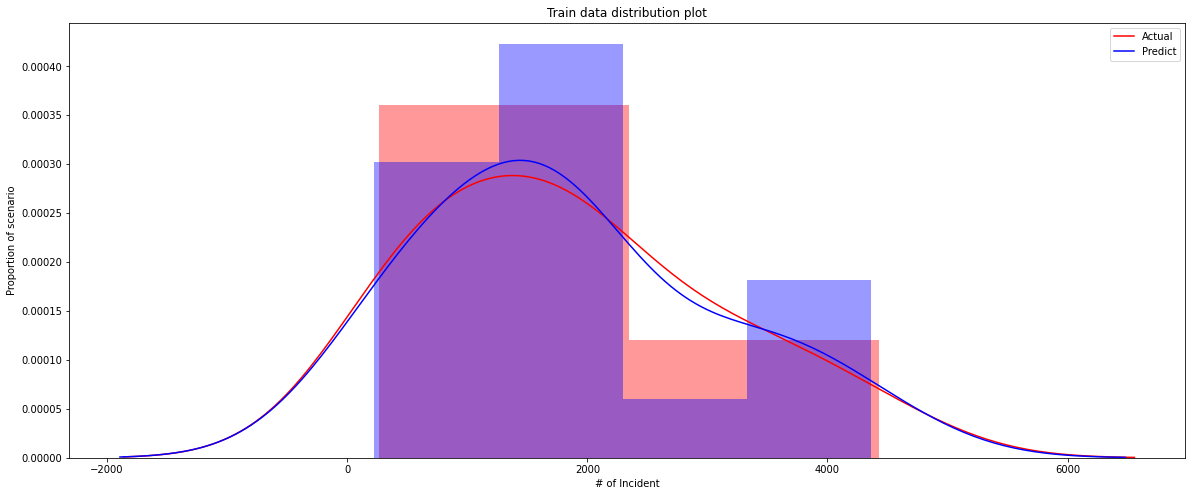

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


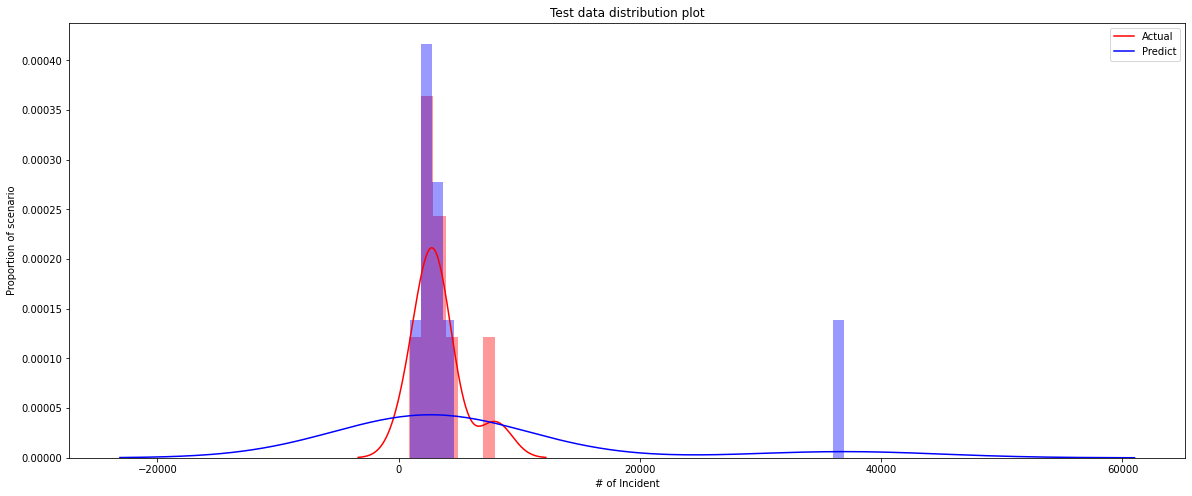

In [68]:
Poly = PolynomialFeatures(degree= 2) #From the Polynomial order evalution as above, identify the best order #
X_train_Poly = Poly.fit_transform(X_train)
X_test_Poly = Poly.fit_transform(X_test)

lr.fit(X_train_Poly, y_train)
Y_hatPoly = lr.predict(X_test_Poly)
Y_train_hatPloy = lr.predict(X_train_Poly)

ModelEvaluation(lr, X, y, X_train_Poly, X_test_Poly, y_train, y_test, Y_hatPoly)

PollyPlot(X_train, X_test, y_train, y_test, lr,Poly)
#Distirubtion Plot(y_test,Y_hatPoly,Features,Target,Period)

DistributionPlot(y_train, Y_train_hatPloy, 'Train data distribution plot')
DistributionPlot(y_test, Y_hatPoly, 'Test data distribution plot')

#### 4.2.2.3 PolyNormial Transformation + Ridge Regression <a name="Model_Eva4223"></a>

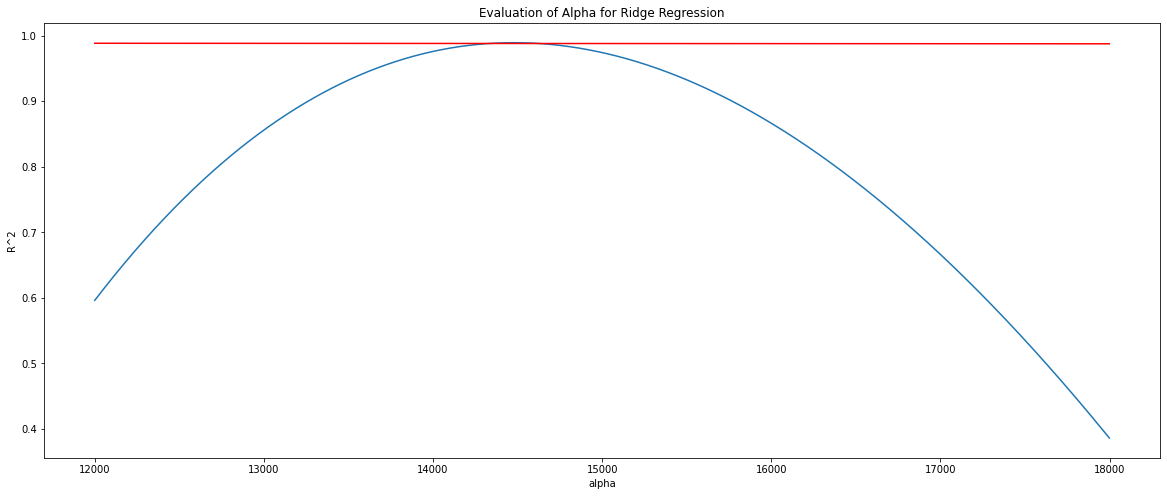

In [74]:
#Ridge Regression
Rsqu_test = []
Rsqu_train = []
dummy1 = []

Poly = PolynomialFeatures(degree= 3)
X_train_Poly = Poly.fit_transform(X_train)
X_test_Poly = Poly.fit_transform(X_test)
#Alpha = np.array(range(1,20))/100
#Alpha = 10 * np.array(range(1,50))
Alpha = np.array(range(12000, 18000))
for a in Alpha:
    Rm = Ridge(alpha=a) 
    Rm.fit(X_train_Poly, y_train)
    Rsqu_test.append(Rm.score(X_test_Poly, y_test))
    Rsqu_train.append(Rm.score(X_train_Poly, y_train))
    
plt.figure(figsize=(20, 8))

plt.plot(Alpha,Rsqu_test, label='validation data  ')
plt.plot(Alpha,Rsqu_train, 'r', label='training Data ')
plt.title("Evaluation of Alpha for Ridge Regression")
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.show()

Predicted values: [[2622.50751807]
 [3741.05151081]
 [8258.99191933]
 [2969.51386191]]
True values: [[2621.]
 [3944.]
 [8020.]
 [3265.]]
Cross Validation Score = [0.5898494  0.57036562 0.7483212 ]
Train R^2 = 0.9879199817693707
Test R^2 = 0.9872814913269212
MSE = 49575.97097863184


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


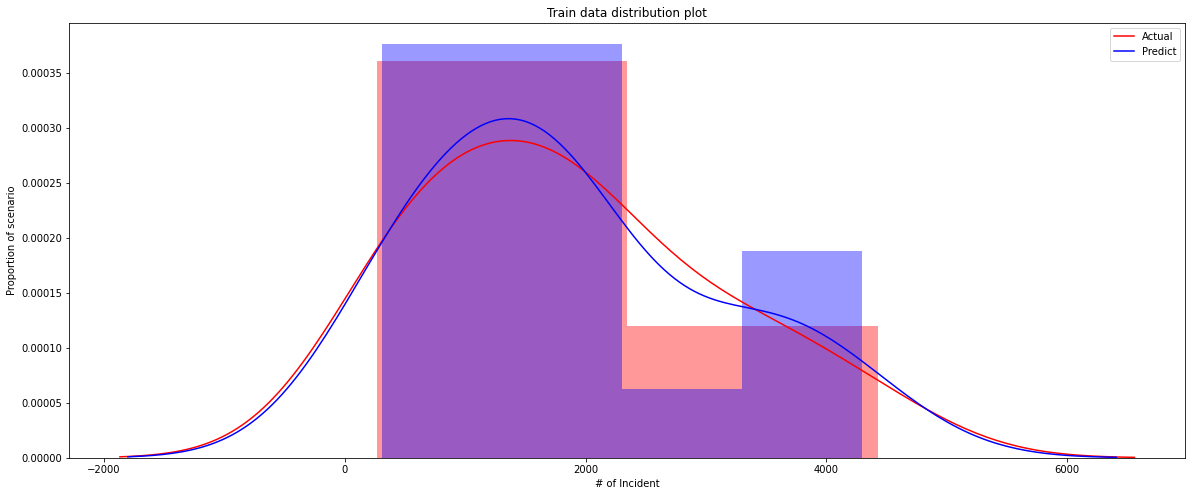

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


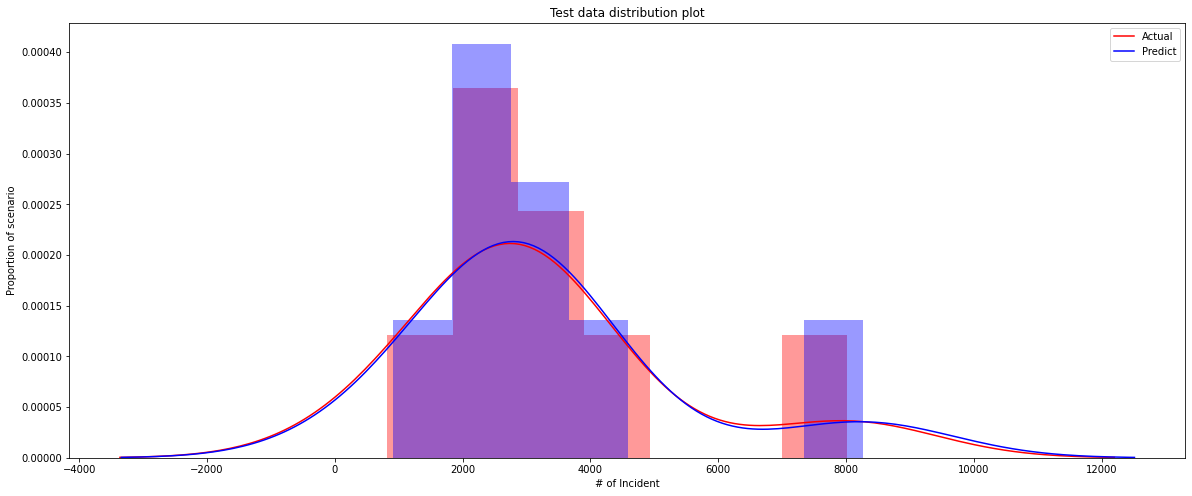

In [72]:
Rm=Ridge(alpha=14300) #Select the best Alphat from the graph
Rm.fit(X_train_Poly, y_train)

Y_hatRm = Rm.predict(X_test_Poly)
Y_train_hatRm = Rm.predict(X_train_Poly)

ModelEvaluation(Rm, X, y, X_train_Poly, X_test_Poly, y_train, y_test, Y_hatRm)


DistributionPlot(y_train, Y_train_hatRm, 'Train data distribution plot')
DistributionPlot(y_test, Y_hatRm, 'Test data distribution plot')

#### 4.2.2.4 Grid CV <a name="Model_Eva4224"></a>
<p hidden>About RM: Figure 6:The blue line represents the R^2 of the validation data, and the red line represents the R^2 of the training data. The x-axis represents the different values of Alpha. Here the model is built and tested on the same data. So the training and test data are the same.
The red line in figure 6 represents the R^2 of the test data.
As Alpha increases the R^2 decreases.
Therefore as Alpha increases the model performs worse on the test data.
The blue line represents the R^2 on the validation data.
As the value for Alpha increases the R^2 increases and converges at a point</p>

Predicted values: [[ 2647.2525384 ]
 [ 3703.34518973]
 [12113.27984628]
 [ 2977.1082484 ]]
True values: [[2621.]
 [3944.]
 [8020.]
 [3265.]]
Cross Validation Score = [0.5898494  0.57036562 0.7483212 ]
Train R^2 = 0.9881498798449598
Test R^2 = 0.4511770601541514
MSE = 2139278.3413197873


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


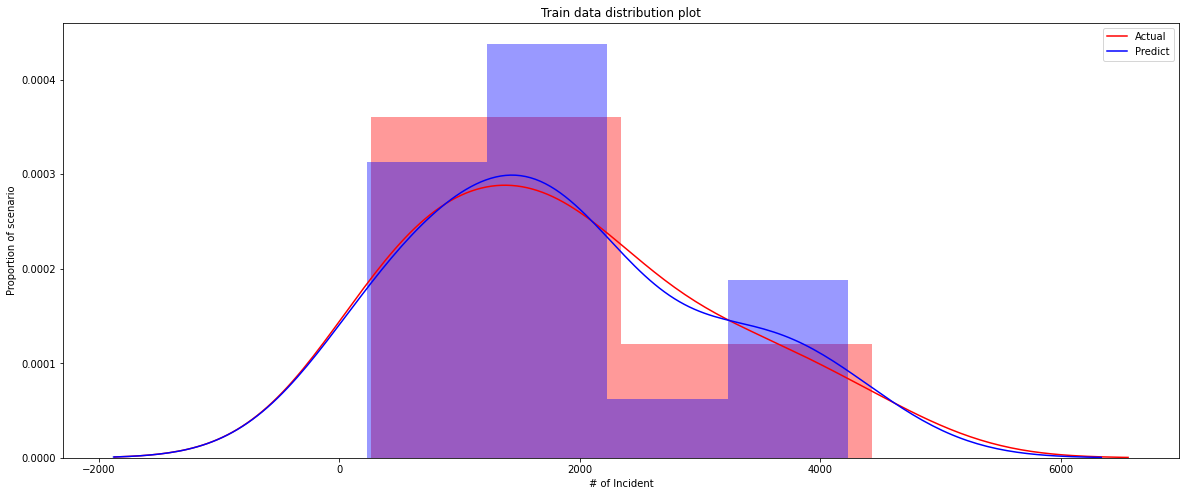

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


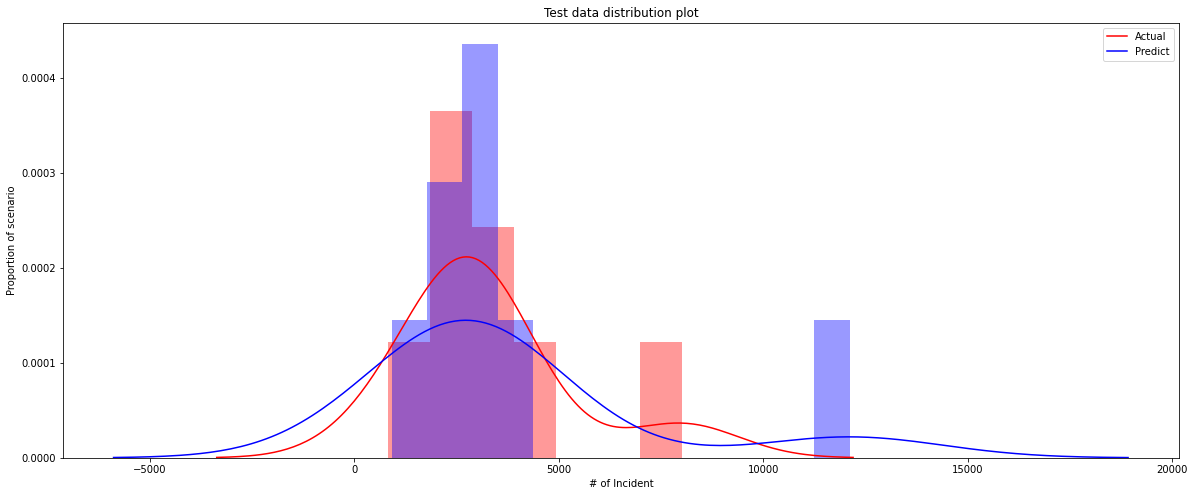

In [77]:
#GridCV -- over Ridge Regression (rm)
parameters1= [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 12000, 14300, 15000, 100000, 100000]}]

Grid1 = GridSearchCV(Rm, parameters1,cv=4)
Grid1.fit(X_train, y_train)

BestRM=Grid1.best_estimator_ #BestRM is the best fitted model with alpha optimized.

BestRM.score(X_test, y_test)

Y_hatBestRM = BestRM.predict(X_test)
Y_train_hatBestRM = BestRM.predict(X_train)

ModelEvaluation(BestRM, X, y, X_train, X_test, y_train, y_test, Y_hatBestRM)

DistributionPlot(y_train, Y_train_hatBestRM, 'Train data distribution plot')
DistributionPlot(y_test, Y_hatBestRM, 'Test data distribution plot')

## 5. Discussion <a name="resultsanddiscussion"></a>

### 5.1 Result
Overall the MSE is with very large value... it may indicate underfitting of the model but with the R2 to be relatively close to 100% which may also indicate a good prediction.  None of those are good models per the MSE but the "Ridge Regression w/h @14300" with "PolyNormial order = 3" may stand out among the models.

The figure also indicates it is very close fit to the training distribution.

HOWEVER, with this data scenario (Junction Type = In Block with interception related, being the factor of Severity 2 incident per Hour), this analysis may only explain that the data are well correlated and with a very poor model.

A couple of other data scenario to be considered too.  Among the other trials, more optimiztic MSE values were found with the same 4 modeling methodologies but with poorer correlation results (poorer prediction accuracies = lower values of R2)
- Weather = Raining, being the factor of Severity 2 incident per day
- Road Condition = wet, being the factor of Severity 2 incident per day


### 5.2 "Is this a suitable dataset for Modeling and Prediction?"
The question above should also been put in our discussion session as well.

<b>Car Sales</b> data like having the vehicle independent features like mpg/100kl,brand,Hp etc., and with the target values like sales price / volumn is a suitable candidate being modeled, trained and make prediction.

<b>Pub/Club business</b> data with independent features like location, tables, facilities, operational hours etc., and with the target values like business revenue / visitors/guests volumn may also be a suitable candidate for modling, training and prediction.

<b>Incidents</b> data may tell a different story here.  While incident happened, some of the features were identified and associated to the incident, NOT before it happened.  As it indicates certain dependancies.

<b>Given some examples:</b>
- "Weather is bad (heavy rain), traffic incidents will highly likely increase".  Possibly, rainy days can be used to predict incidents numbers related to rain.  Even technically possible, what can we do when it rains?

- "Marijuana became legal and being sold just like alcohol to people, impaired driving incidents will increase". Likely be, put on reinforcement to stop impaired driving will prevent it from happening.  But we donot have that piece of data ("Under influence" or "Impaired driving") <b>BEFORE</b> accidents happen.

- "Certain part of the city is out of eletricity, lights were gone, incidents will increase".  Good fit maybe, that is incident itself as well and the infrastructure department is working hard to reduce the risks of power shut.  HOWEVER, most of the situations occured in good lighting condition according to the data.  What do we do?

- "There are poorly planned interceptions or signals are unclear/broken, incidents will increase".  Yes, taken to consideration of improving interception design and signal installation should reduce the risk of incidents.  Same problem happens here, that we donot have the information ("Junction Type") <b>BEFORE</b> incidents happen.

- "Increase in local gang activities, speeding and impaired driving incidents may increase"... Probably but very much very blur and unclear about data involvement.

"Dependence is the problem".  HOWEVER, according to the exploratory analysis, we have identified some relationships between the features and Severity 2 incidents.  Now let's STILL make some attempts to build a model for one of the scenario, traing and evaluation the model and make some prediction, even in the author's opinion it may not be th perfect dataset for modling and prediction.

## 6. Conclusion <a name="conclusion"></a>

Seattle is a beautiful city, and also famous of its America northern west coast climate -- long, greyish and raining fall/winter.  Driving in well developed city like Seattle should be safe, and the data shows it is only becoming safer.

Most of the incident occured without too significant cause.   And it seems more reasonable to keep doing what the city has been doing right:  Improve the road (wider/flatter roads with better tractions, and lighting), the interception design (visibility, signals, flow controls), reinforce traffic bylaws (Speeding, Impaired driving),
specific road user segements will help reduce the collision to especially cyclists and pedestrains, and so on.

We may have drill down further to find out if there are predictibility potentials, by developing more models and try out some other data combinations.  HOWEVER, just like in the discussion session ... with the yet happened incident(s), we may ONLY take projection from data from elsewhere like Speeding, Impaired Driving, infrastructure construction, population, weather station statistics.